In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import duckdb
import warnings
warnings.filterwarnings("ignore")

# Approach

Considering the first task, we will start assuming that both files, transactions 1 and 2, are the same data from different days. In this notebook we will focus entirely in searching for anomalies and creating models to monitor and detect such anomalies.

In [5]:
transactions = pd.read_csv('transactions_1.csv')
transactions

,time,status,f0_
0,00h 00,approved,9
1,00h 00,denied,6
2,00h 00,refunded,1
3,00h 01,denied,8
4,00h 01,approved,13
...,...,...,...
4229,23h 59,processing,4
4230,23h 59,denied,1
4231,23h 59,backend_reversed,5
4232,23h 59,approved,10


In [6]:
transactions = duckdb.query("""
SELECT ts.time as time, ts.status as status, ts.f0_ as count
FROM transactions as ts

""").df()

In [7]:
transactions['time'] = pd.to_datetime(transactions['time'], format='%Hh %M').dt.strftime('%H:%M')

<h4>Pivoting status count per hour</h4>

In [9]:
transactions = transactions.sort_values('time')

transactions = transactions.pivot_table(['count'], 'time', 'status').droplevel(0, axis=1)
transactions.columns = ['approved','backend_reversed','denied','failed','processing','refunded','reversed']
transactions.fillna(0, inplace=True)

transactions.reset_index(inplace=True)



transactions

,time,approved,backend_reversed,denied,failed,processing,refunded,reversed
0,00:00,9.0,0.0,6.0,0.0,0.0,1.0,0.0
1,00:01,13.0,0.0,8.0,0.0,0.0,0.0,0.0
2,00:02,11.0,0.0,7.0,0.0,0.0,1.0,0.0
3,00:03,12.0,0.0,3.0,0.0,0.0,0.0,0.0
4,00:04,11.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1317,23:55,32.0,0.0,4.0,0.0,0.0,0.0,0.0
1318,23:56,30.0,0.0,3.0,0.0,0.0,0.0,0.0
1319,23:57,21.0,0.0,4.0,0.0,0.0,0.0,1.0
1320,23:58,11.0,4.0,3.0,0.0,3.0,1.0,2.0


In [16]:
print('_ % NaNs  ________')
for col in transactions.columns:
    pct = transactions[f'{col}'].isnull().sum() * 100 / len(transactions.index)
    print(f'{col} - {pct}%')

_ % NaNs  ________
time - 0.0%
approved - 0.0%
backend_reversed - 0.0%
denied - 0.0%
failed - 0.0%
processing - 0.0%
refunded - 0.0%
reversed - 0.0%


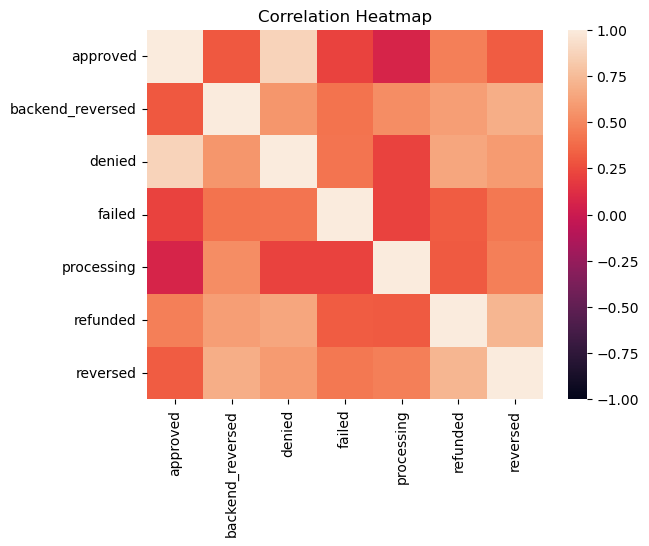

In [9]:
sns.heatmap(transactions.drop('time', axis=1).corr(), vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

*Denied* and *Approved* transactions are very strongly correlated. With this, we can create a Linear Regression model to predict the denied transactions based on the approved ones. If the model makes a prediction of denials, and the reality is too far from the prediction, it should be considered anomalous. The distance will be calculated by the square difference between prediction and reality

### Data Augmentation

In [17]:
from sklearn.linear_model import LinearRegression

transactions['denied_approved'] = (transactions.denied / (transactions.approved+0.1))*100
transactions['denied_pct'] = (transactions.denied / (transactions.approved
                                                 + transactions.backend_reversed
                                                 + transactions.denied
                                                 + transactions.failed
                                                 + transactions.processing
                                                 + transactions.refunded
                                                 + transactions.reversed))*100

transactions['reversed'] = transactions['reversed'] + transactions['backend_reversed']
transactions['reversed_approved'] =  (transactions.reversed / (transactions.approved+0.1))*100
transactions['reversed_pct'] = (transactions.reversed / (transactions.approved                                                 
                                                 + transactions.denied
                                                 + transactions.failed
                                                 + transactions.processing
                                                 + transactions.refunded
                                                 + transactions.reversed))*100

transactions['failed_approved'] =  (transactions.failed / (transactions.approved+0.1))*100
transactions['failed_pct'] = (transactions.failed / (transactions.approved                                                 
                                                 + transactions.denied
                                                 + transactions.failed
                                                 + transactions.processing
                                                 + transactions.refunded
                                                 + transactions.reversed))*100

transactions['failed_pct_diff'] = (transactions.failed - transactions.approved)/((transactions.failed+transactions.approved)/2)
transactions['denied_pct_diff'] = (transactions.denied - transactions.approved)/((transactions.denied+transactions.approved)/2)
transactions['reversed_pct_diff'] = (transactions.reversed - transactions.approved)/((transactions.reversed+transactions.approved)/2)

transactions['approved_pct'] = (transactions.approved / (transactions.approved                                                 
                                                 + transactions.denied
                                                 + transactions.failed
                                                 + transactions.processing
                                                 + transactions.refunded
                                                 + transactions.reversed))*100




# For denied transactions, we will use linear regression to measure distance of data point from hypothesis
X, y = np.array(transactions.approved).reshape(-1, 1), transactions.denied
linearR_denied = LinearRegression().fit(X,y)
score = linearR_denied.score(X,y)
print(f'Linear Regression score: {score}')
predicted_denied = linearR_denied.predict(X)

transactions['denied_sqr_distance'] = (transactions.denied - predicted_denied)**2


transactions = transactions.replace(np.nan, 0)

Linear Regression score: 0.7497136384496553


In [18]:
for col in transactions.columns:
    pct = transactions[f'{col}'].isnull().sum() * 100 / len(transactions.index)
    print(f'{col} - {pct}%')

time - 0.0%
approved - 0.0%
backend_reversed - 0.0%
denied - 0.0%
failed - 0.0%
processing - 0.0%
refunded - 0.0%
reversed - 0.0%
denied_approved - 0.0%
denied_pct - 0.0%
reversed_approved - 0.0%
reversed_pct - 0.0%
failed_approved - 0.0%
failed_pct - 0.0%
failed_pct_diff - 0.0%
denied_pct_diff - 0.0%
reversed_pct_diff - 0.0%
approved_pct - 0.0%
denied_sqr_distance - 0.0%


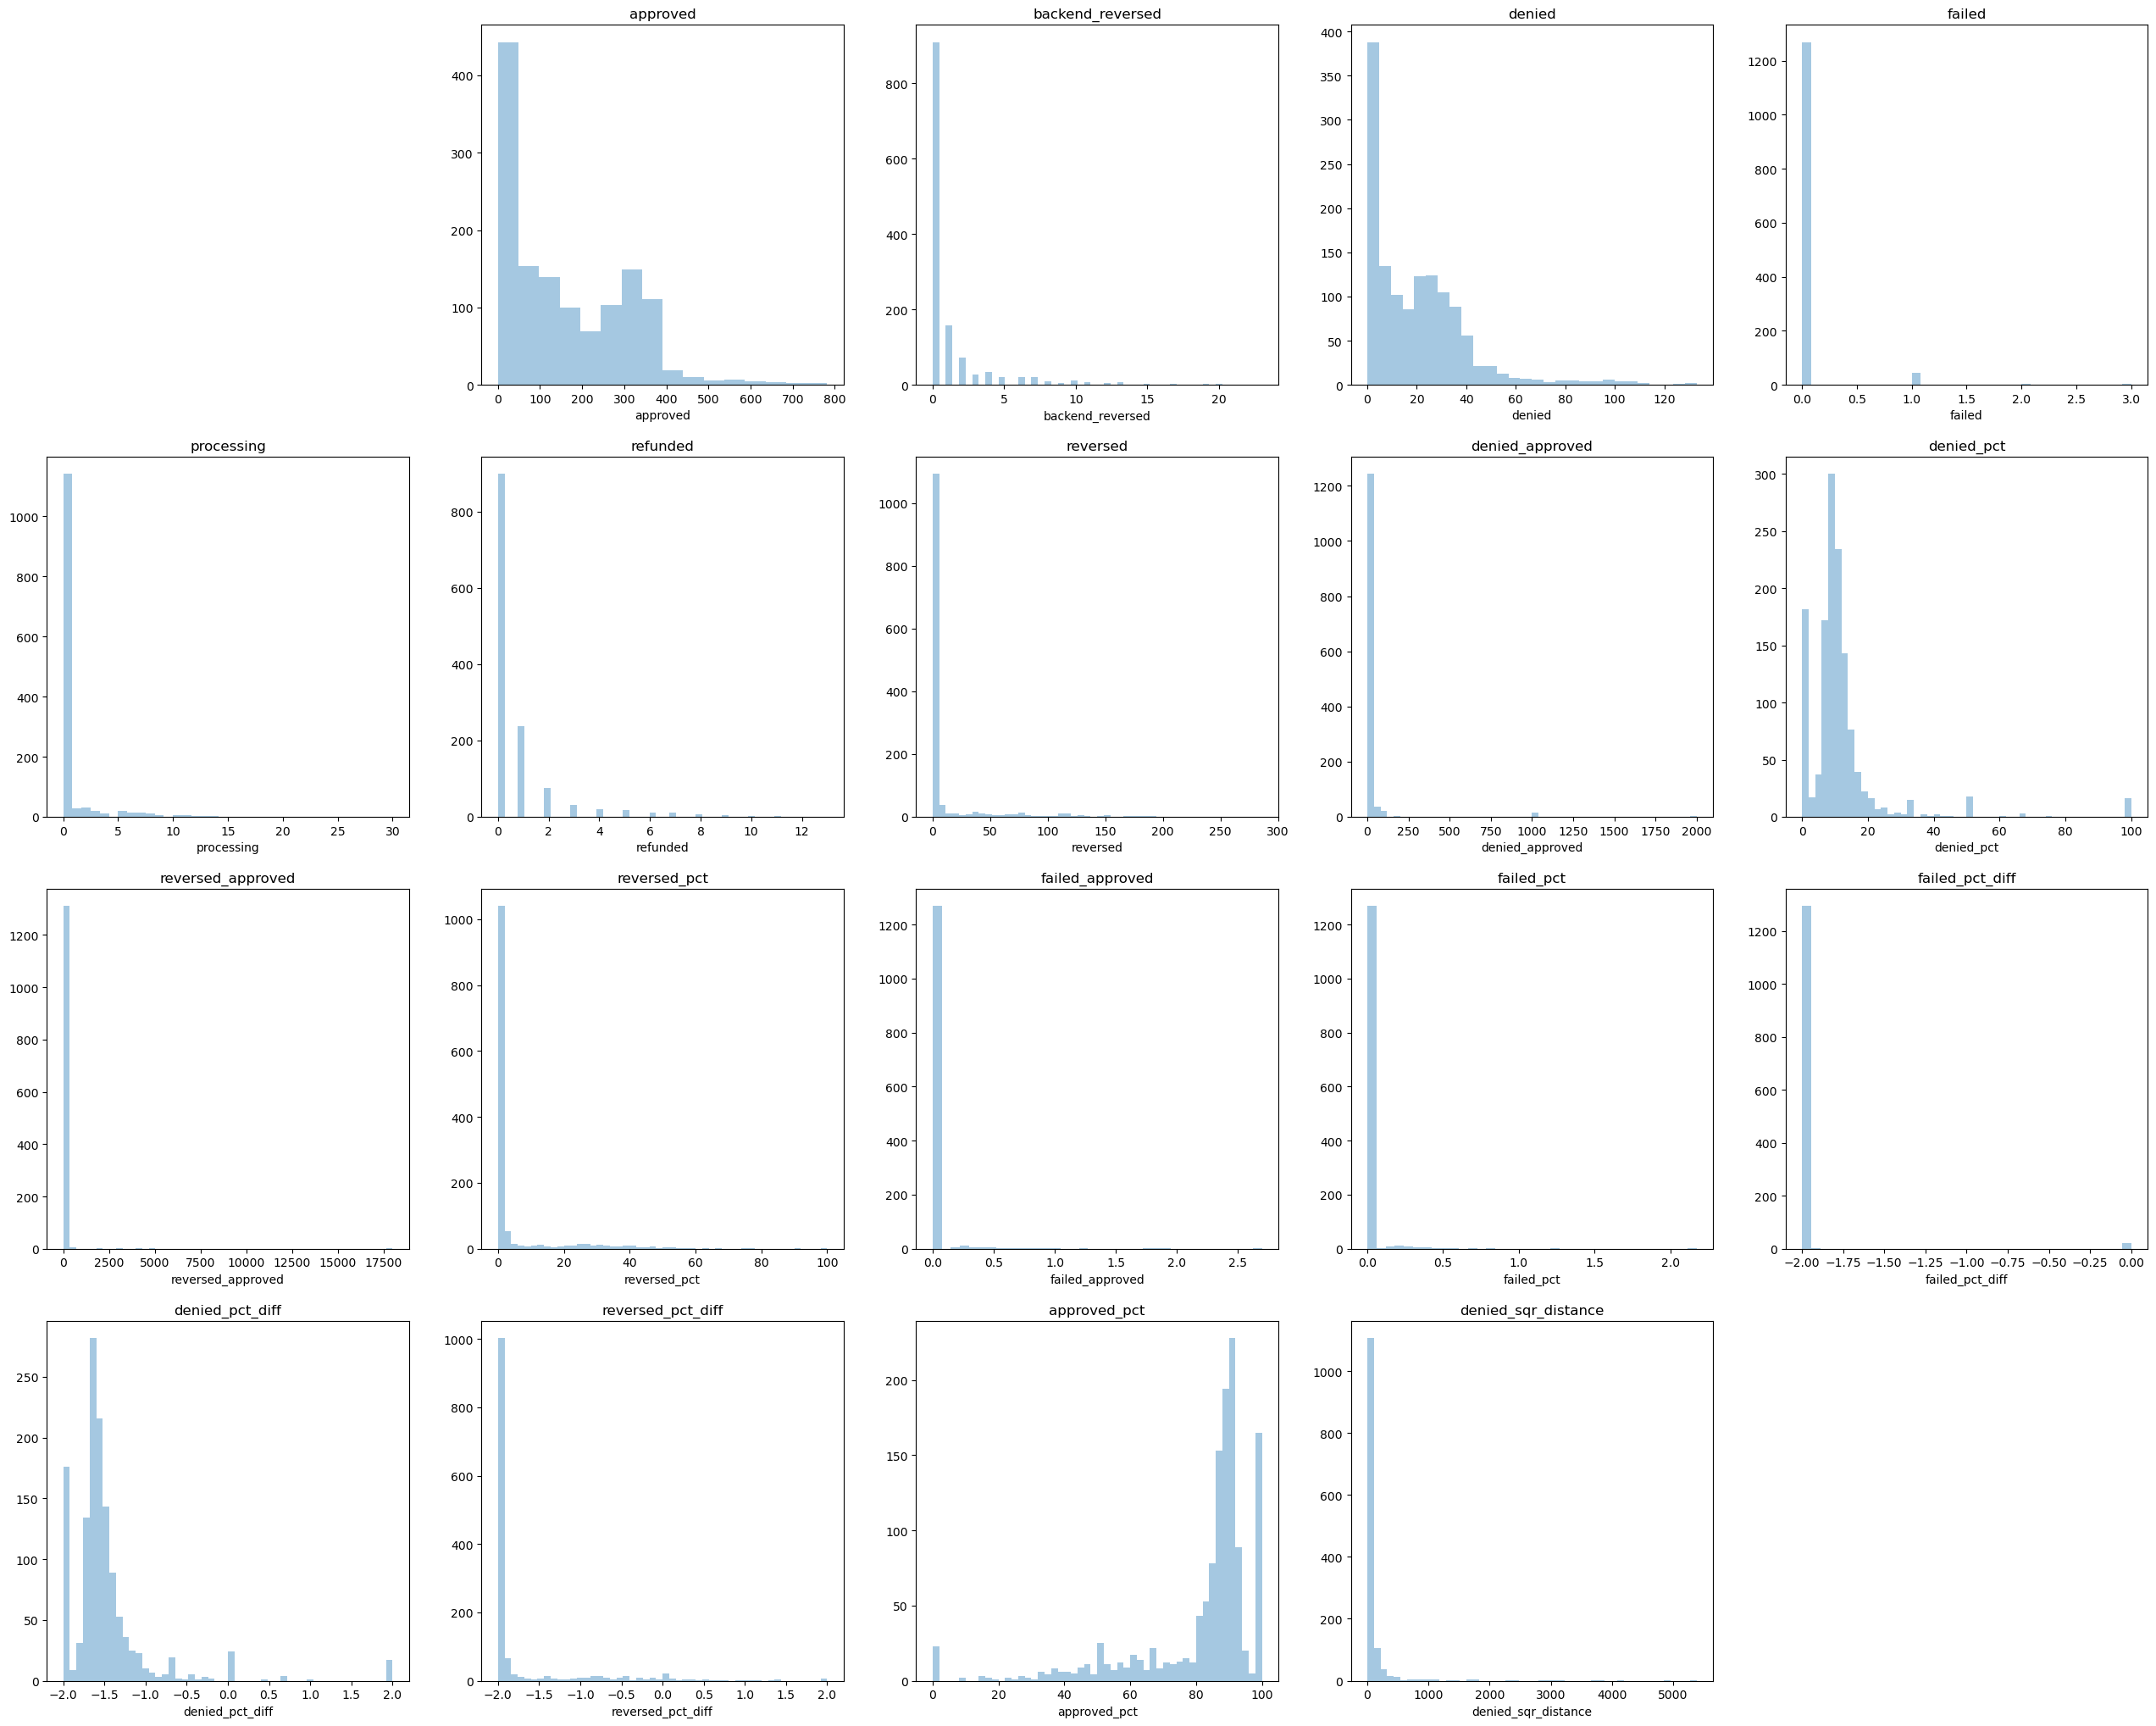

In [19]:

fig = plt.figure(figsize=(32,32))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, col in enumerate(transactions.columns):
    if col=='time':continue
    
    

  
    ax = fig.add_subplot(5, 5, i+1)
    sns.distplot(transactions[col], kde=False, ax=ax)    
    
    ax.set_title(col)


plt.show()

In [20]:
transactions['hour'] = transactions.time.str[:2]
transactions.hour

0       00
1       00
2       00
3       00
4       00
        ..
1317    23
1318    23
1319    23
1320    23
1321    23
Name: hour, Length: 1322, dtype: object

In [21]:
transactions.drop('backend_reversed', axis=1, inplace=True)
transactions.drop('time', axis=1, inplace=True)

**One Hot Encoder for each Hour**

In [22]:
transactions = pd.get_dummies(transactions, 'hour', dtype=int)
transactions

,approved,denied,failed,processing,refunded,reversed,denied_approved,denied_pct,reversed_approved,reversed_pct,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.0,6.0,0.0,0.0,1.0,0.0,65.934066,37.500000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,13.0,8.0,0.0,0.0,0.0,0.0,61.068702,38.095238,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,11.0,7.0,0.0,0.0,1.0,0.0,63.063063,36.842105,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,12.0,3.0,0.0,0.0,0.0,0.0,24.793388,20.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,11.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,32.0,4.0,0.0,0.0,0.0,0.0,12.461059,11.111111,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
1318,30.0,3.0,0.0,0.0,0.0,0.0,9.966777,9.090909,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
1319,21.0,4.0,0.0,0.0,0.0,1.0,18.957346,15.384615,4.739336,3.846154,...,0,0,0,0,0,0,0,0,0,1
1320,11.0,3.0,0.0,3.0,1.0,6.0,27.027027,12.500000,54.054054,25.000000,...,0,0,0,0,0,0,0,0,0,1


In [23]:
transactions.columns

Index(['approved', 'denied', 'failed', 'processing', 'refunded', 'reversed',
       'denied_approved', 'denied_pct', 'reversed_approved', 'reversed_pct',
       'failed_approved', 'failed_pct', 'failed_pct_diff', 'denied_pct_diff',
       'reversed_pct_diff', 'approved_pct', 'denied_sqr_distance', 'hour_00',
       'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06',
       'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [24]:
for col in transactions.columns:
    pct = transactions[f'{col}'].isnull().sum() * 100 / len(transactions.index)
    print(f'{col} - {pct}%')

approved - 0.0%
denied - 0.0%
failed - 0.0%
processing - 0.0%
refunded - 0.0%
reversed - 0.0%
denied_approved - 0.0%
denied_pct - 0.0%
reversed_approved - 0.0%
reversed_pct - 0.0%
failed_approved - 0.0%
failed_pct - 0.0%
failed_pct_diff - 0.0%
denied_pct_diff - 0.0%
reversed_pct_diff - 0.0%
approved_pct - 0.0%
denied_sqr_distance - 0.0%
hour_00 - 0.0%
hour_01 - 0.0%
hour_02 - 0.0%
hour_03 - 0.0%
hour_04 - 0.0%
hour_05 - 0.0%
hour_06 - 0.0%
hour_07 - 0.0%
hour_08 - 0.0%
hour_09 - 0.0%
hour_10 - 0.0%
hour_11 - 0.0%
hour_12 - 0.0%
hour_13 - 0.0%
hour_14 - 0.0%
hour_15 - 0.0%
hour_16 - 0.0%
hour_17 - 0.0%
hour_18 - 0.0%
hour_19 - 0.0%
hour_20 - 0.0%
hour_21 - 0.0%
hour_22 - 0.0%
hour_23 - 0.0%


## Isolation Forest

We will be using Isolation Forest as our model of choice for the anomaly detection

In [26]:
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing


X = transactions


scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)

all_features = X.columns

#_Failed__________________________________________________________________________________________________________________
X1 = X.drop(['approved_pct','approved','denied','processing','refunded','reversed','denied_sqr_distance'],axis=1)


X1 = X1.drop(['denied_approved','denied_pct','reversed_approved','reversed_pct'],axis=1)

features = X1.columns
print('X1 Features:')
print([c for c in features])

#_Denied__________________________________________________________________________________________________________________

X2 = X.drop(['denied_approved','processing','refunded','reversed', 'reversed_pct_diff', 'failed_pct_diff', 'denied_pct_diff'],axis=1)


X2 = X2.drop(['failed','failed_approved','failed_pct','reversed_approved','reversed_pct'],axis=1)

features = X2.columns
print('X2 Features:')
print([c for c in features])

#_Reversed__________________________________________________________________________________________________________________
X3 = X.drop(['approved','denied','processing','refunded','denied_sqr_distance', 'failed_pct_diff', 'denied_pct_diff'],axis=1)


X3 = X3.drop(['failed','failed_approved','failed_pct','denied_approved','denied_pct','reversed_approved'],axis=1)

features = X3.columns
print('X3 Features:')
print([c for c in features])





#___________________________________________________________________________________________________________________
#Defining KMeans with 1 cluster
clf_failed =  IsolationForest( random_state=0)
#Fitting the algorithm
clf_failed.fit(X1)

pred_failed = clf_failed.score_samples(X1)
#___________________________________________________________________________________________________________________
#Defining KMeans with 1 cluster
clf_denied =  IsolationForest( random_state=0, contamination=0.05)
#Fitting the algorithm
clf_denied.fit(X2)

pred_denied = clf_denied.score_samples(X2)
#___________________________________________________________________________________________________________________
#Defining KMeans with 1 cluster
clf_reversed =  IsolationForest( random_state=0)
#Fitting the algorithm
clf_reversed.fit(X3)

pred_reversed = clf_reversed.score_samples(X3)


X1 Features:
['failed', 'failed_approved', 'failed_pct', 'failed_pct_diff', 'denied_pct_diff', 'reversed_pct_diff', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']
X2 Features:
['approved', 'denied', 'denied_pct', 'approved_pct', 'denied_sqr_distance', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']
X3 Features:
['reversed', 'reversed_pct', 'reversed_pct_diff', 'approved_pct', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', '

# Why remove numerical?

Because the algorithms will determine that the moments where transactions are fewer, are anomalies. In theory it is correct, but it is not the anomaly analysis we are looking for. What matters is the amount of failed and denied transactions, based on the amount of total transactions. To not "distract" the algorithms from this, we will remove most of the raw numbers.

In [27]:
predicted_df = pd.DataFrame(scaler.inverse_transform(X), columns=all_features)
predicted_df['pred_failed'] = pred_failed *-1
predicted_df['pred_denied'] = pred_denied *-1
predicted_df['pred_reversed'] = pred_reversed *-1
predicted_df

,approved,denied,failed,processing,refunded,reversed,denied_approved,denied_pct,reversed_approved,reversed_pct,...,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pred_failed,pred_denied,pred_reversed
0,9.0,6.0,0.0,0.0,1.0,0.0,65.934066,37.500000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.412862,0.410570,0.381138
1,13.0,8.0,0.0,0.0,0.0,0.0,61.068702,38.095238,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.408546,0.410759,0.371597
2,11.0,7.0,0.0,0.0,1.0,0.0,63.063063,36.842105,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.408546,0.409165,0.379889
3,12.0,3.0,0.0,0.0,0.0,0.0,24.793388,20.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.389232,0.381557,0.357562
4,11.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383590,0.376663,0.363605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,32.0,4.0,0.0,0.0,0.0,0.0,12.461059,11.111111,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.366356,0.368552,0.353829
1318,30.0,3.0,0.0,0.0,0.0,0.0,9.966777,9.090909,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.367655,0.368343,0.354788
1319,21.0,4.0,0.0,0.0,0.0,1.0,18.957346,15.384615,4.739336,3.846154,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.368646,0.371296,0.370444
1320,11.0,3.0,0.0,3.0,1.0,6.0,27.027027,12.500000,54.054054,25.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.391274,0.396518,0.413833


<Axes: xlabel='reversed_pct', ylabel='approved_pct'>

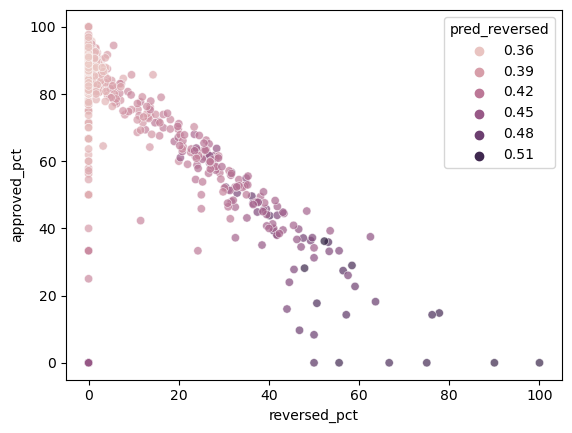

In [28]:
sns.scatterplot(x="reversed_pct", y="approved_pct", hue="pred_reversed", data=predicted_df, alpha=0.7)

<Axes: xlabel='denied_pct', ylabel='approved_pct'>

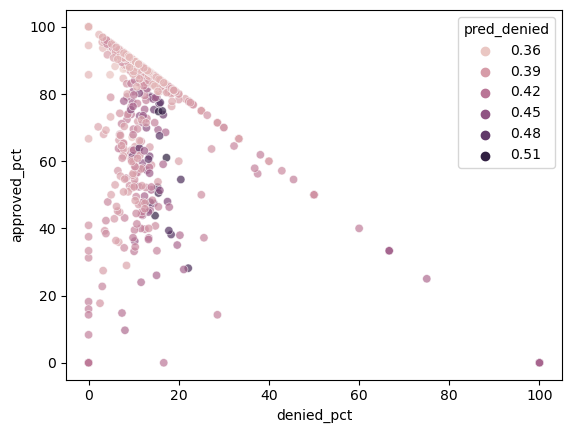

In [29]:
sns.scatterplot(x="denied_pct", y="approved_pct", hue="pred_denied", data=predicted_df, alpha=0.7)

<Axes: xlabel='failed_pct', ylabel='approved_pct'>

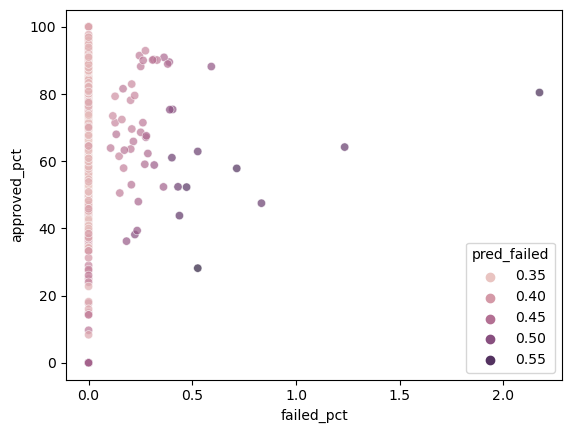

In [30]:
sns.scatterplot(x="failed_pct", y="approved_pct", hue="pred_failed", data=predicted_df, alpha=0.7)

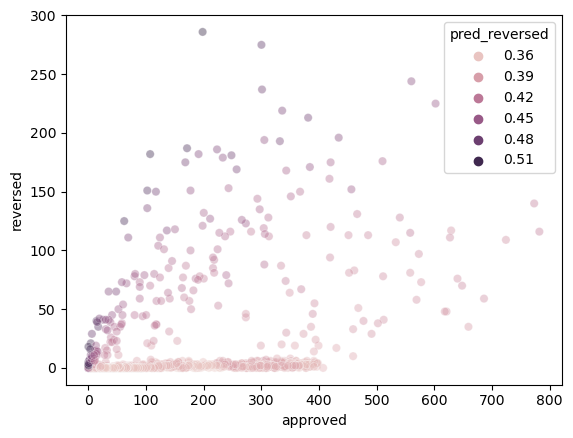

In [31]:
ax = sns.scatterplot(x="approved", y="reversed", hue="pred_reversed", data=predicted_df, alpha=0.4)

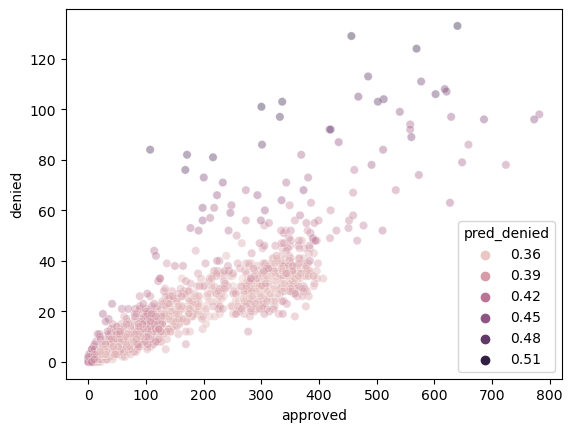

In [32]:
ax = sns.scatterplot(x="approved", y="denied", hue="pred_denied", data=predicted_df, alpha=0.4)

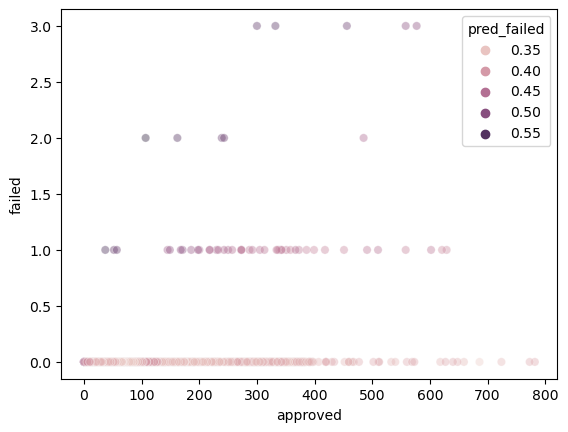

In [33]:
ax = sns.scatterplot(x="approved", y="failed", hue="pred_failed", data=predicted_df, alpha=0.4)

In [36]:
predicted_df['anomaly_failed'] = predicted_df.pred_failed>0.5
predicted_df.groupby('anomaly_failed').count()

,approved,denied,failed,processing,refunded,reversed,denied_approved,denied_pct,reversed_approved,reversed_pct,...,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pred_failed,pred_denied,pred_reversed
anomaly_failed,,,,,,,,,,,,,,,,,,,,,
False,1311,1311,1311,1311,1311,1311,1311,1311,1311,1311,...,1311,1311,1311,1311,1311,1311,1311,1311,1311,1311
True,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11


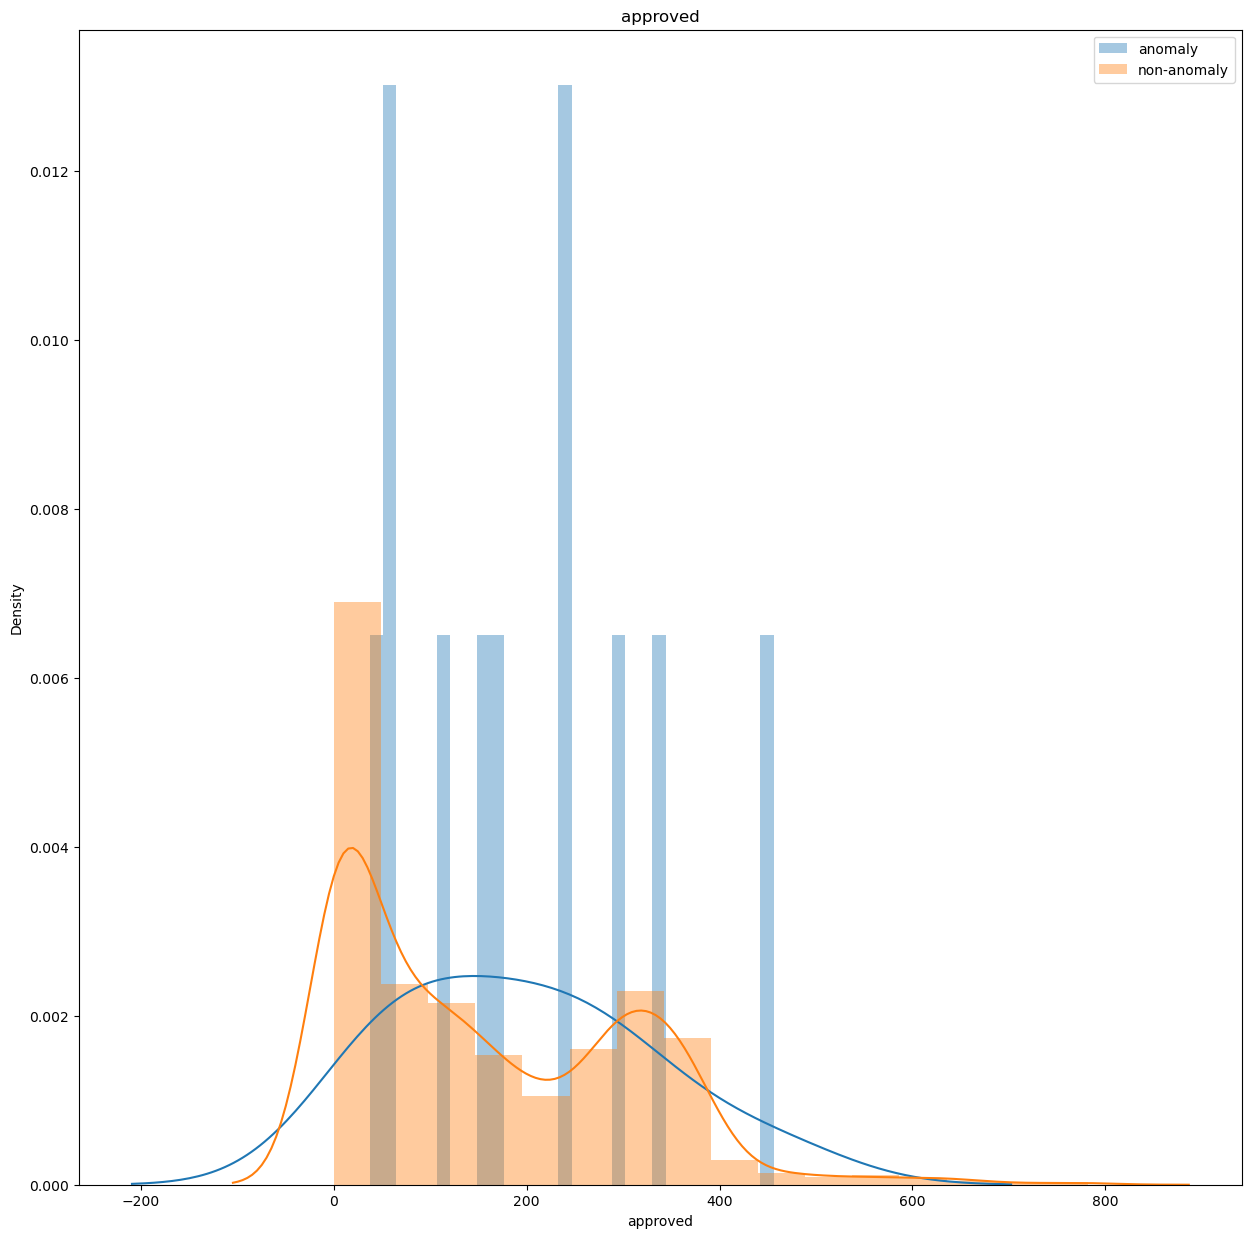

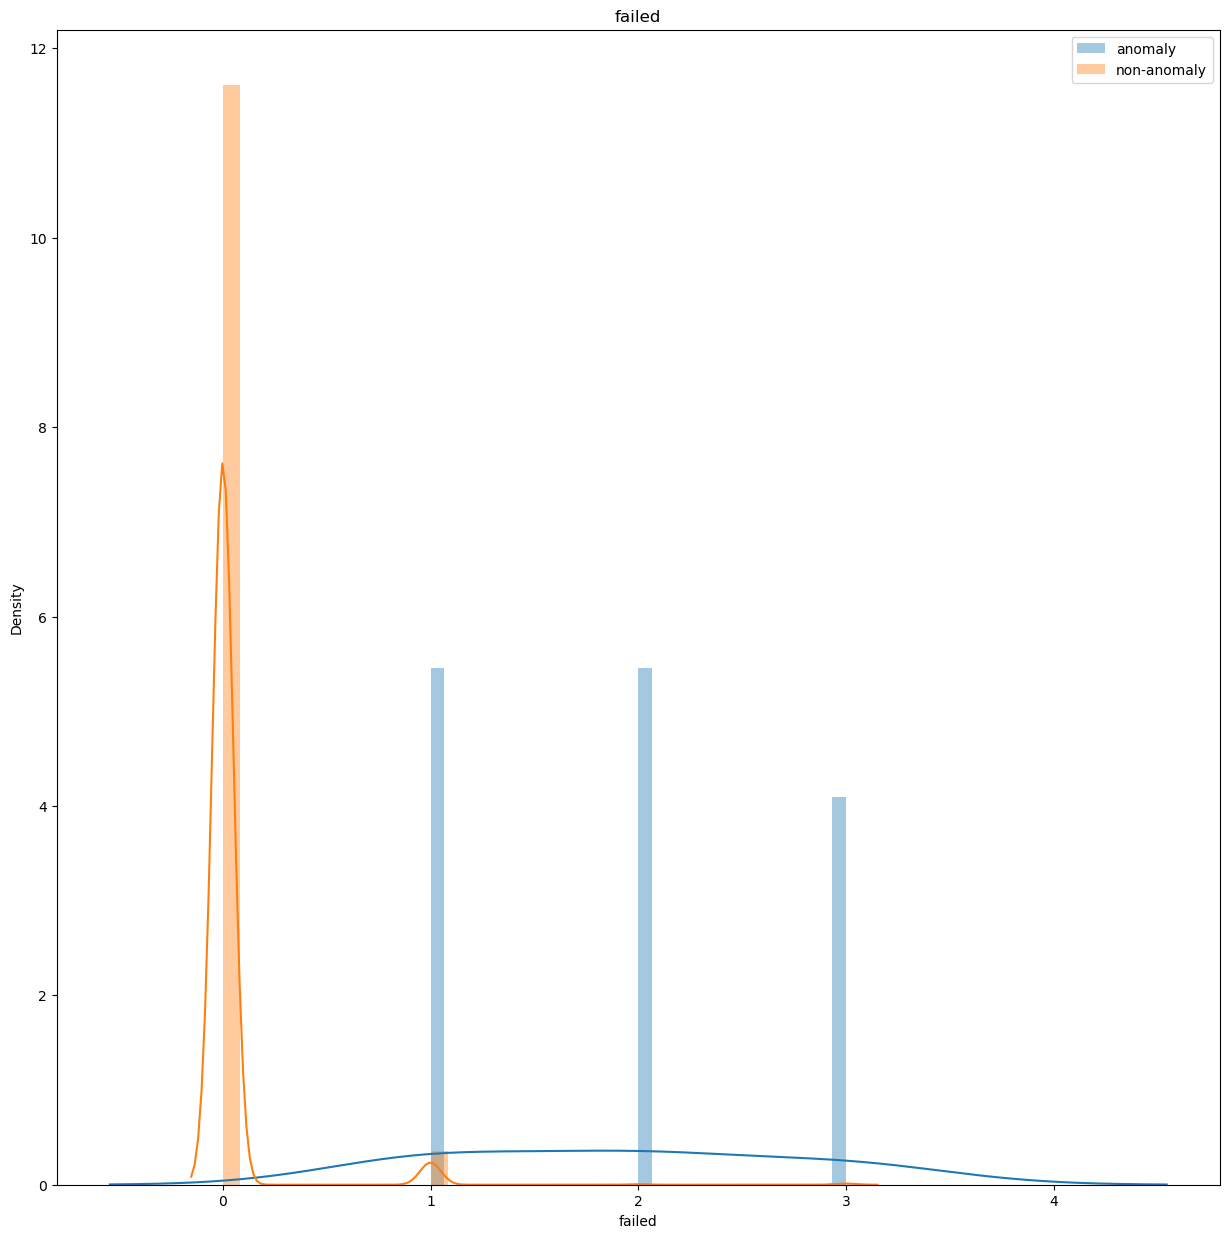

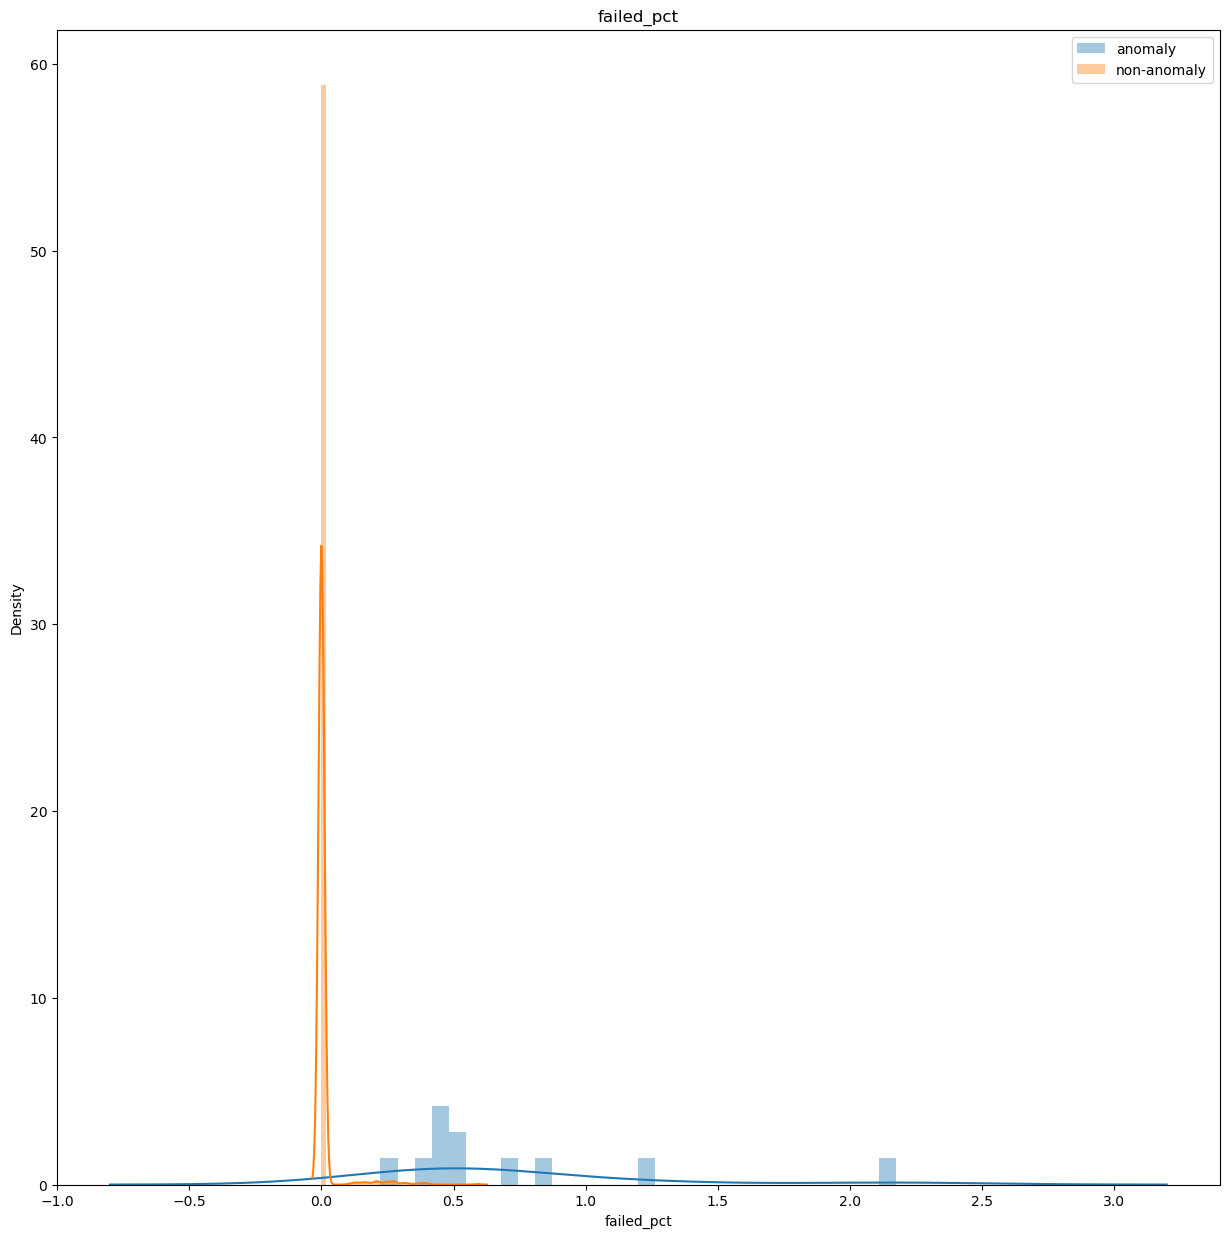

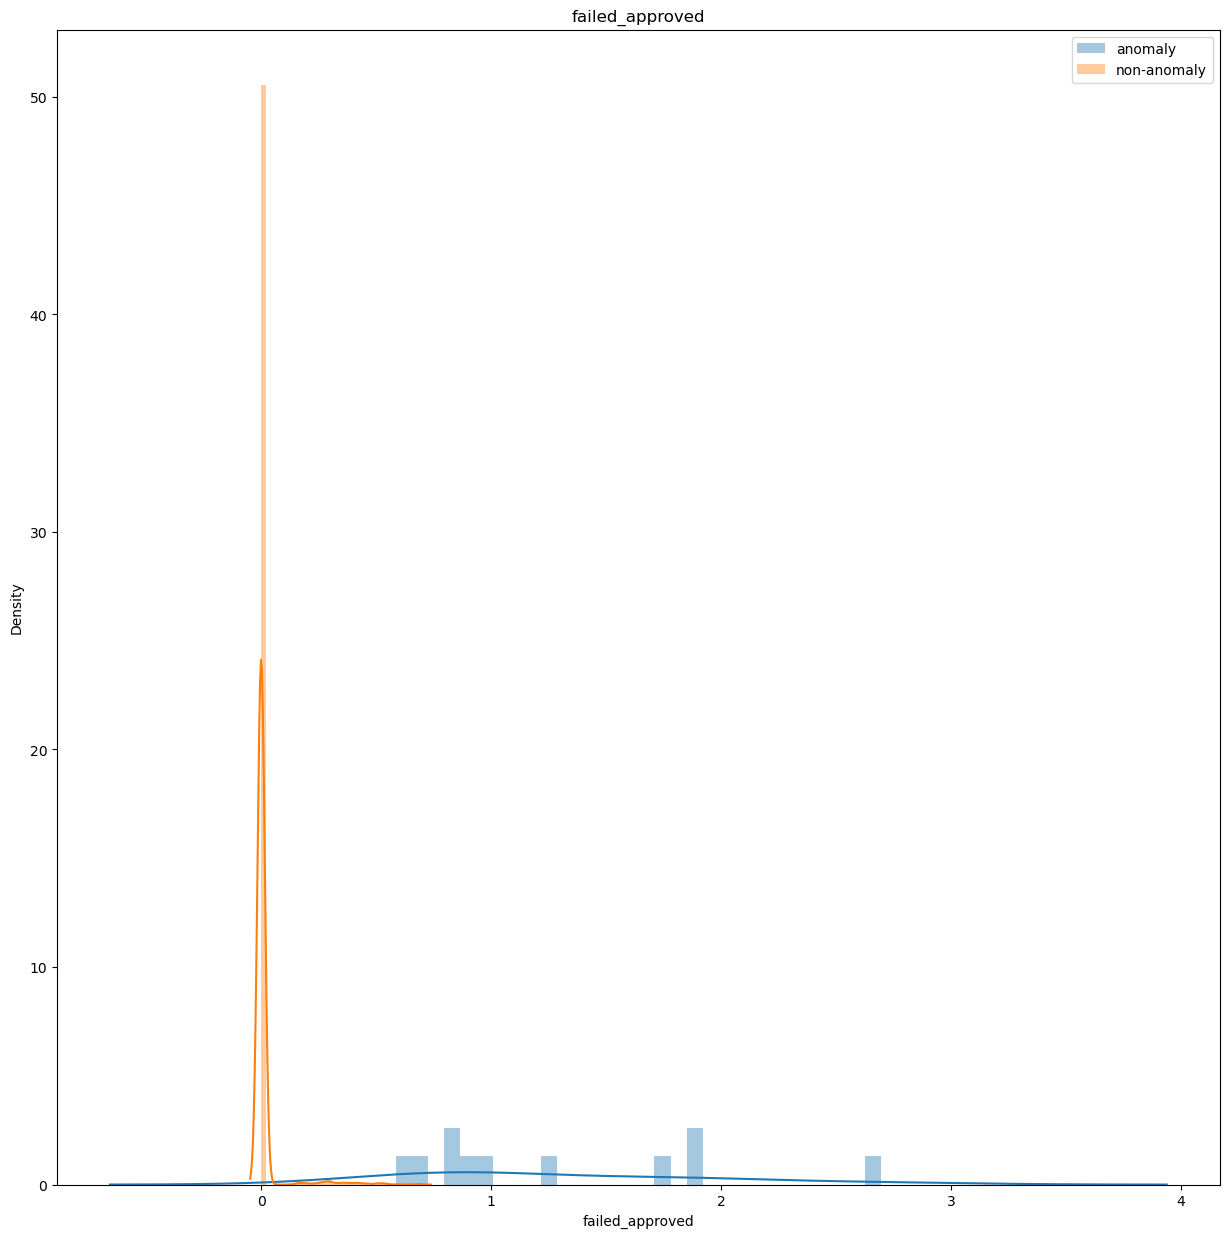

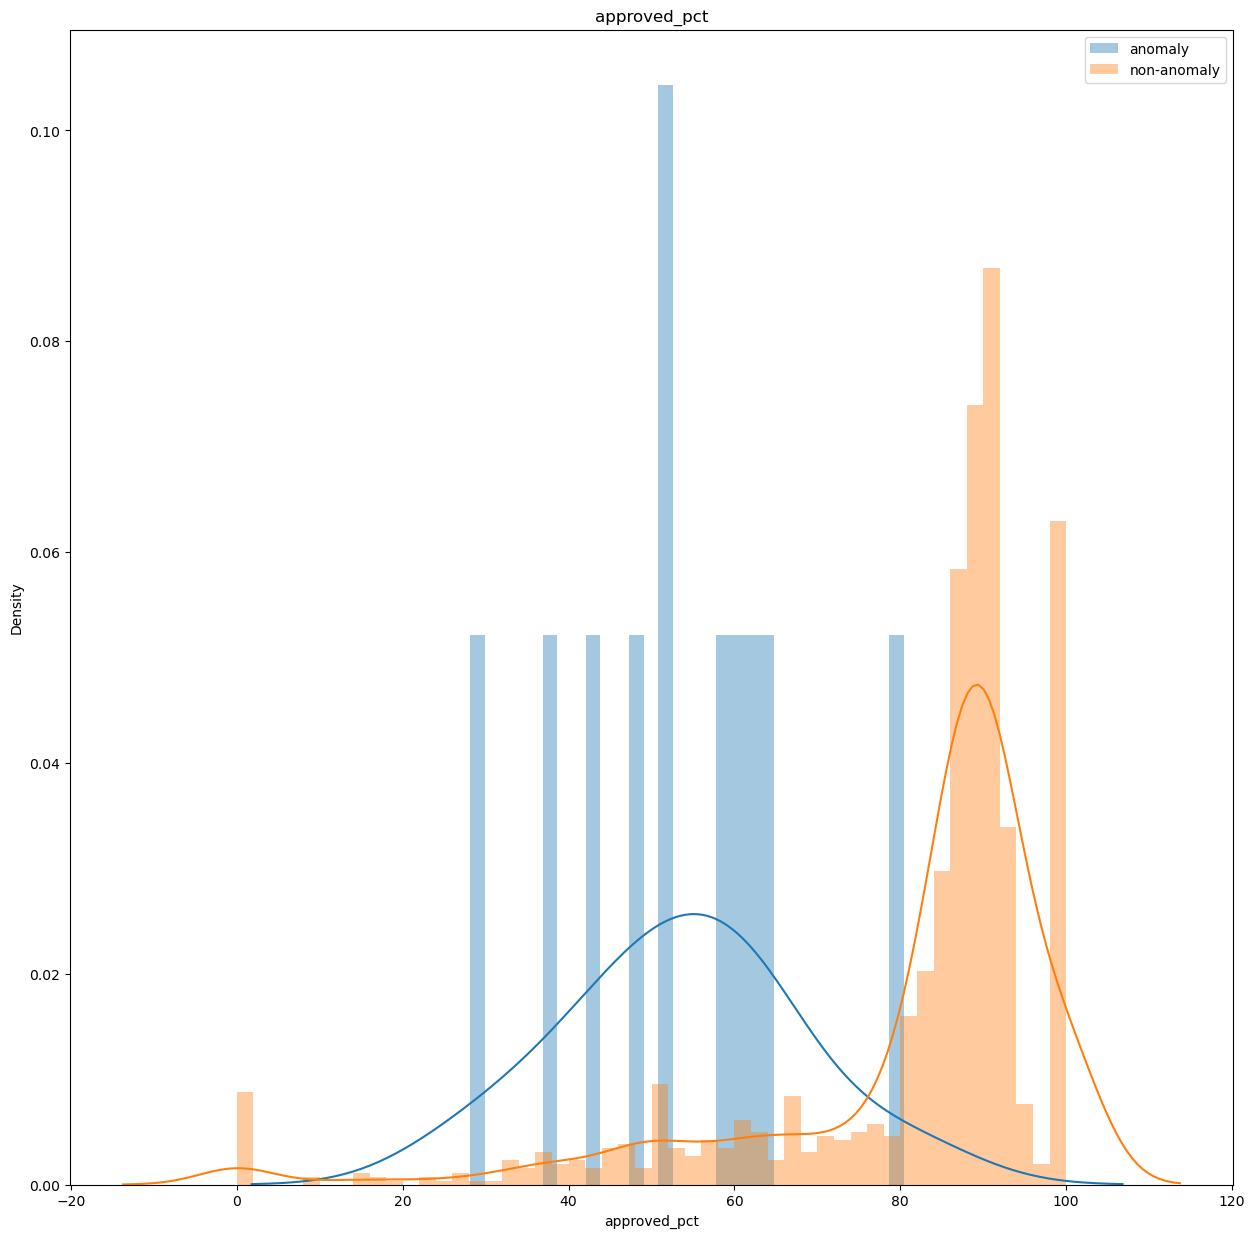

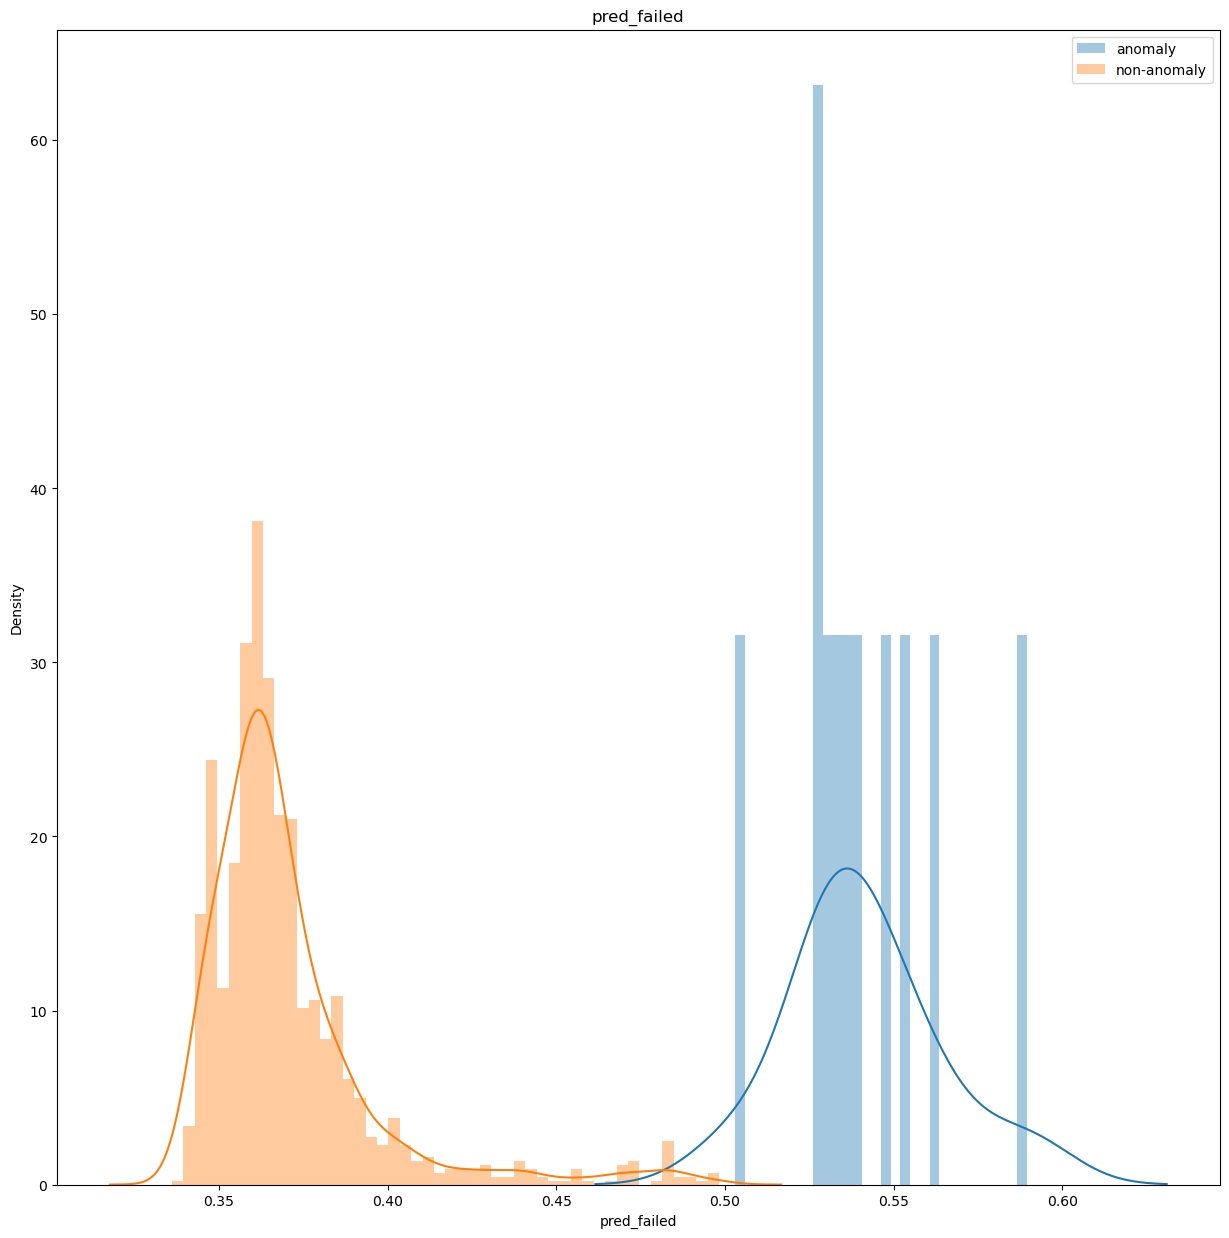

In [37]:
for i, col in enumerate(['approved','failed','failed_pct','failed_approved','approved_pct','pred_failed']):
    if col=='time':continue
    
    fig = plt.figure(figsize=(15,15))

  
    
    sns.distplot(predicted_df[predicted_df.anomaly_failed==True][col],label='anomaly', bins = 30)   
    sns.distplot(predicted_df[predicted_df.anomaly_failed==False][col], label='non-anomaly') 
    plt.legend()
    plt.title(col)

    plt.show()



In [40]:
predicted_df['anomaly_denied'] = predicted_df.pred_denied>0.44
predicted_df.groupby('anomaly_denied').count()

,approved,denied,failed,processing,refunded,reversed,denied_approved,denied_pct,reversed_approved,reversed_pct,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pred_failed,pred_denied,pred_reversed,anomaly_failed
anomaly_denied,,,,,,,,,,,,,,,,,,,,,
False,1271,1271,1271,1271,1271,1271,1271,1271,1271,1271,...,1271,1271,1271,1271,1271,1271,1271,1271,1271,1271
True,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51


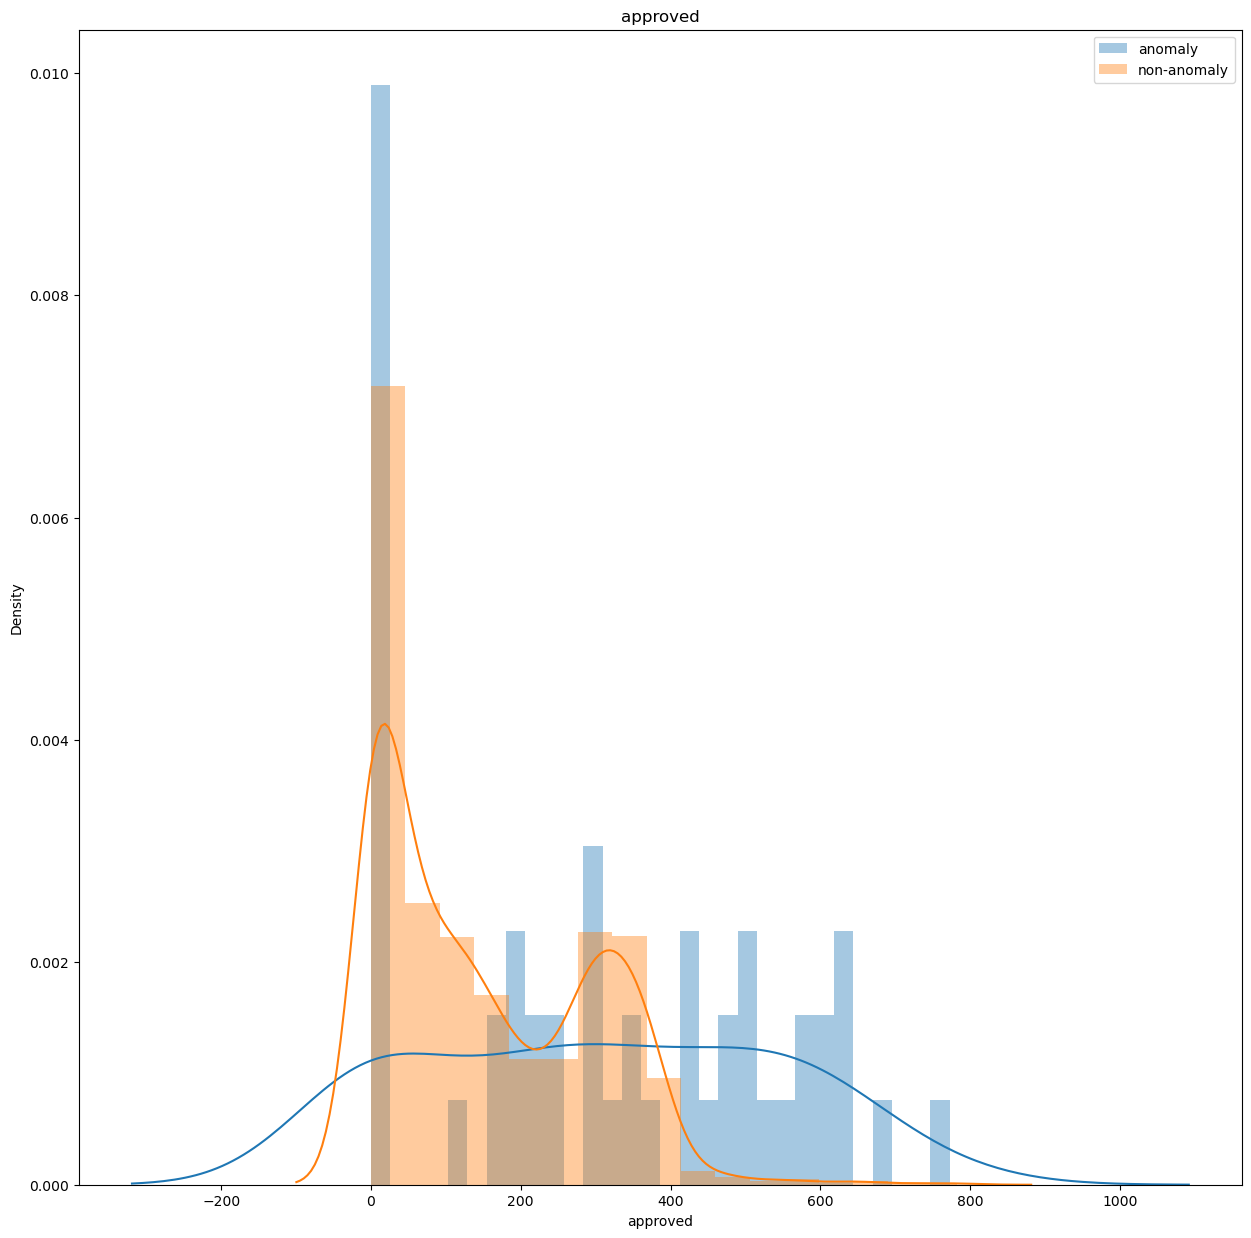

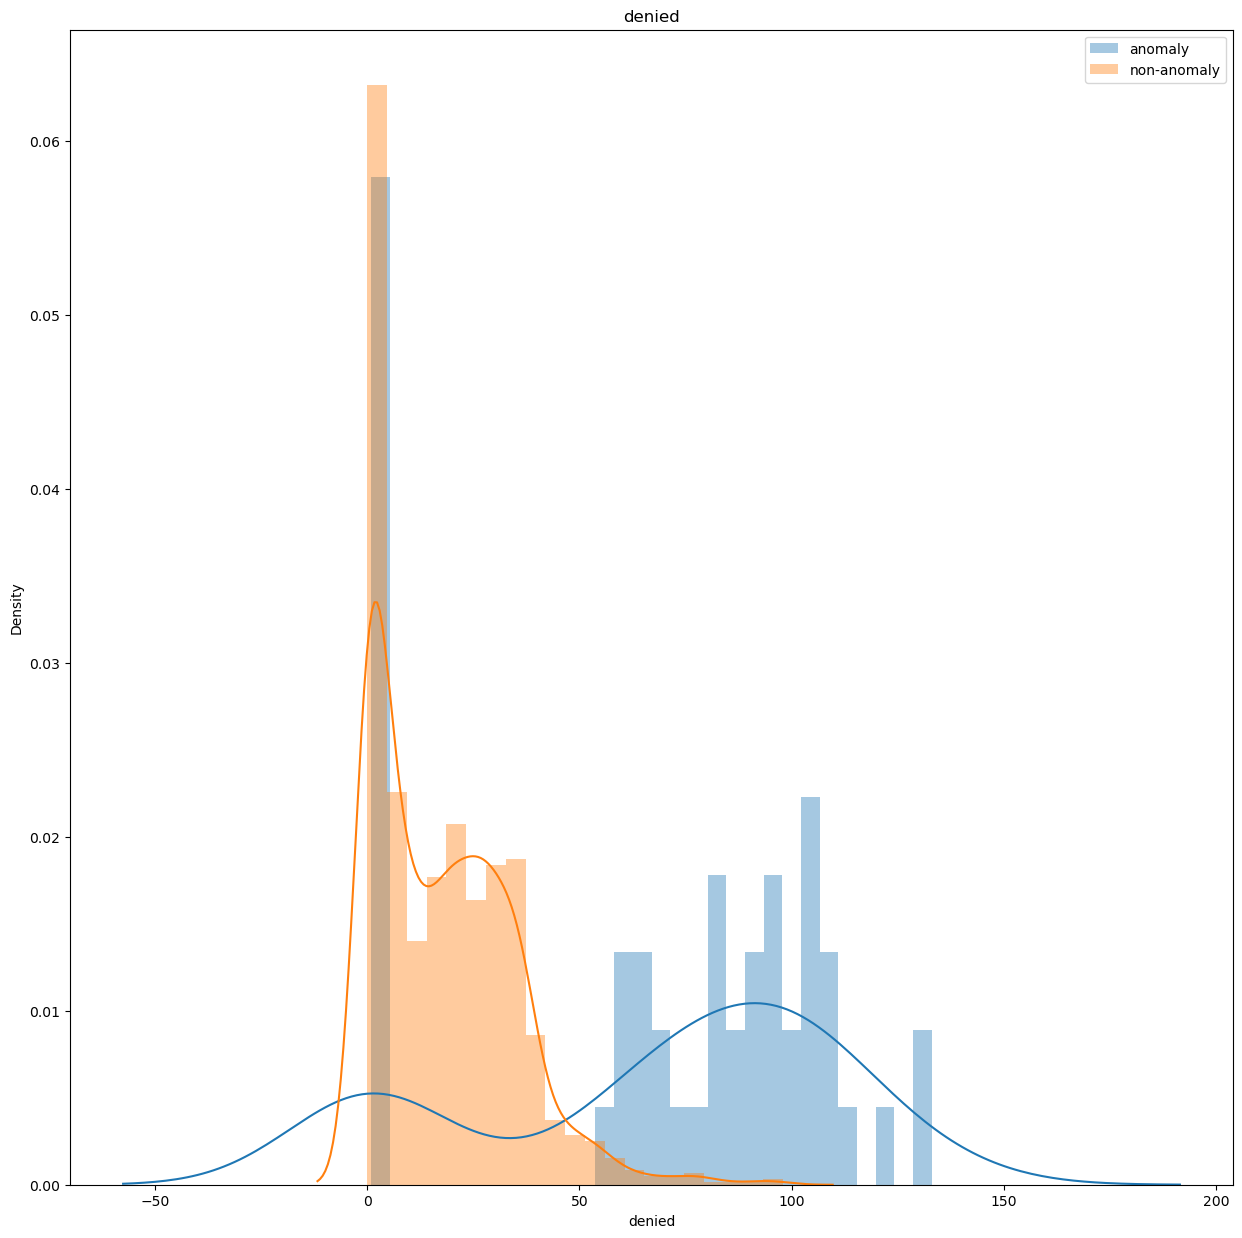

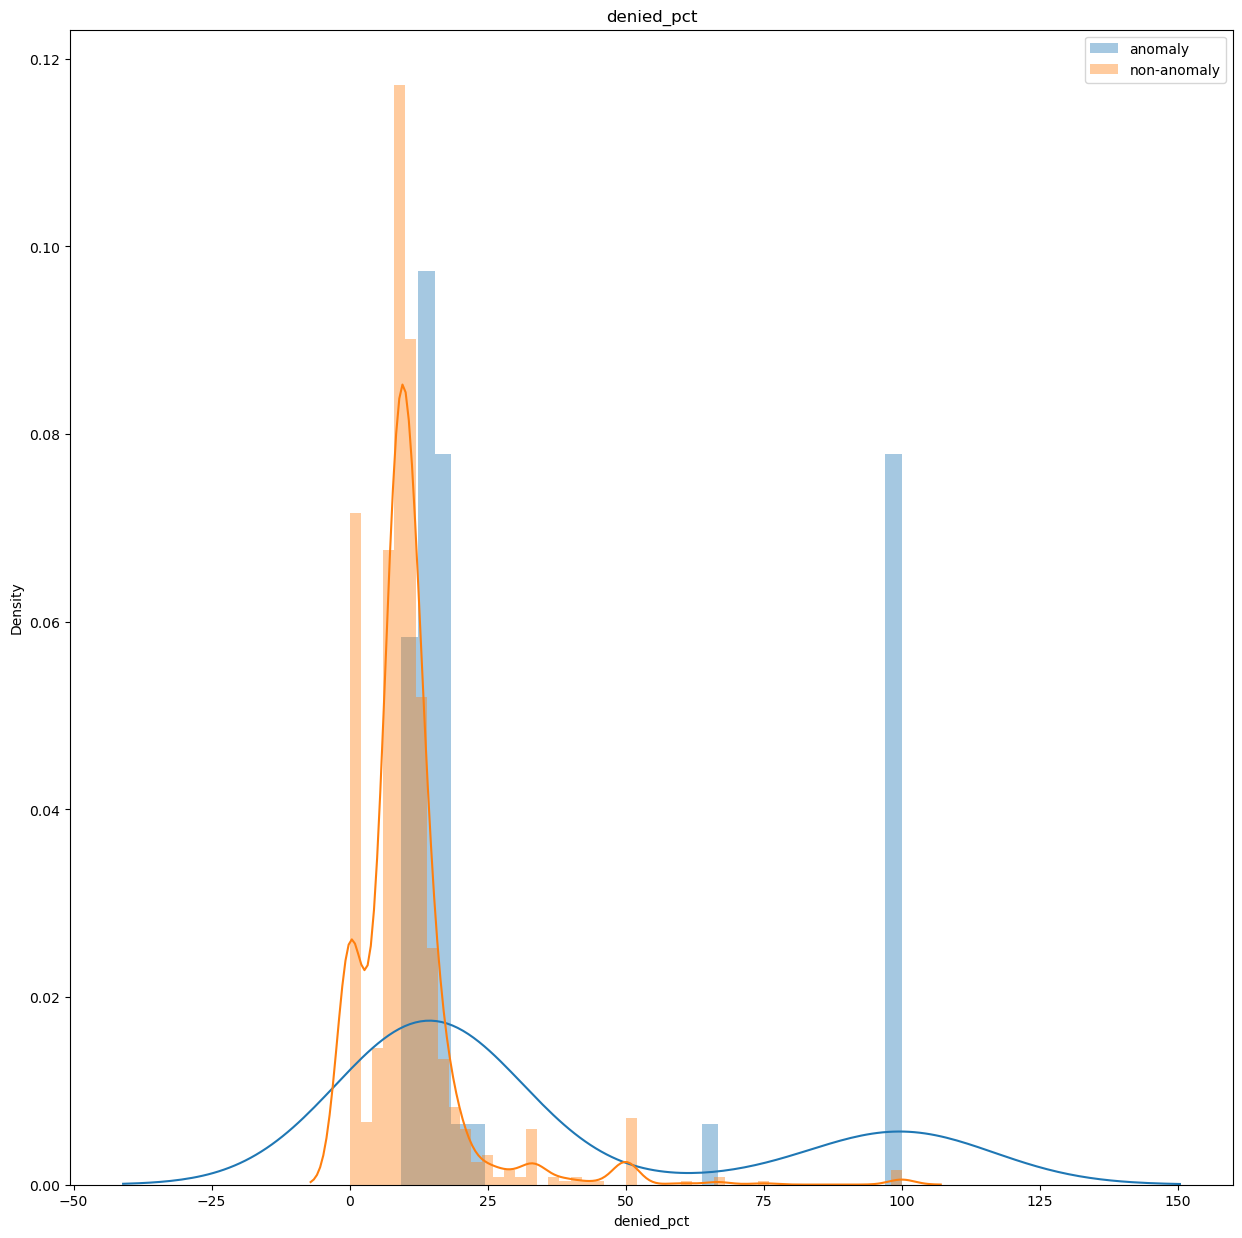

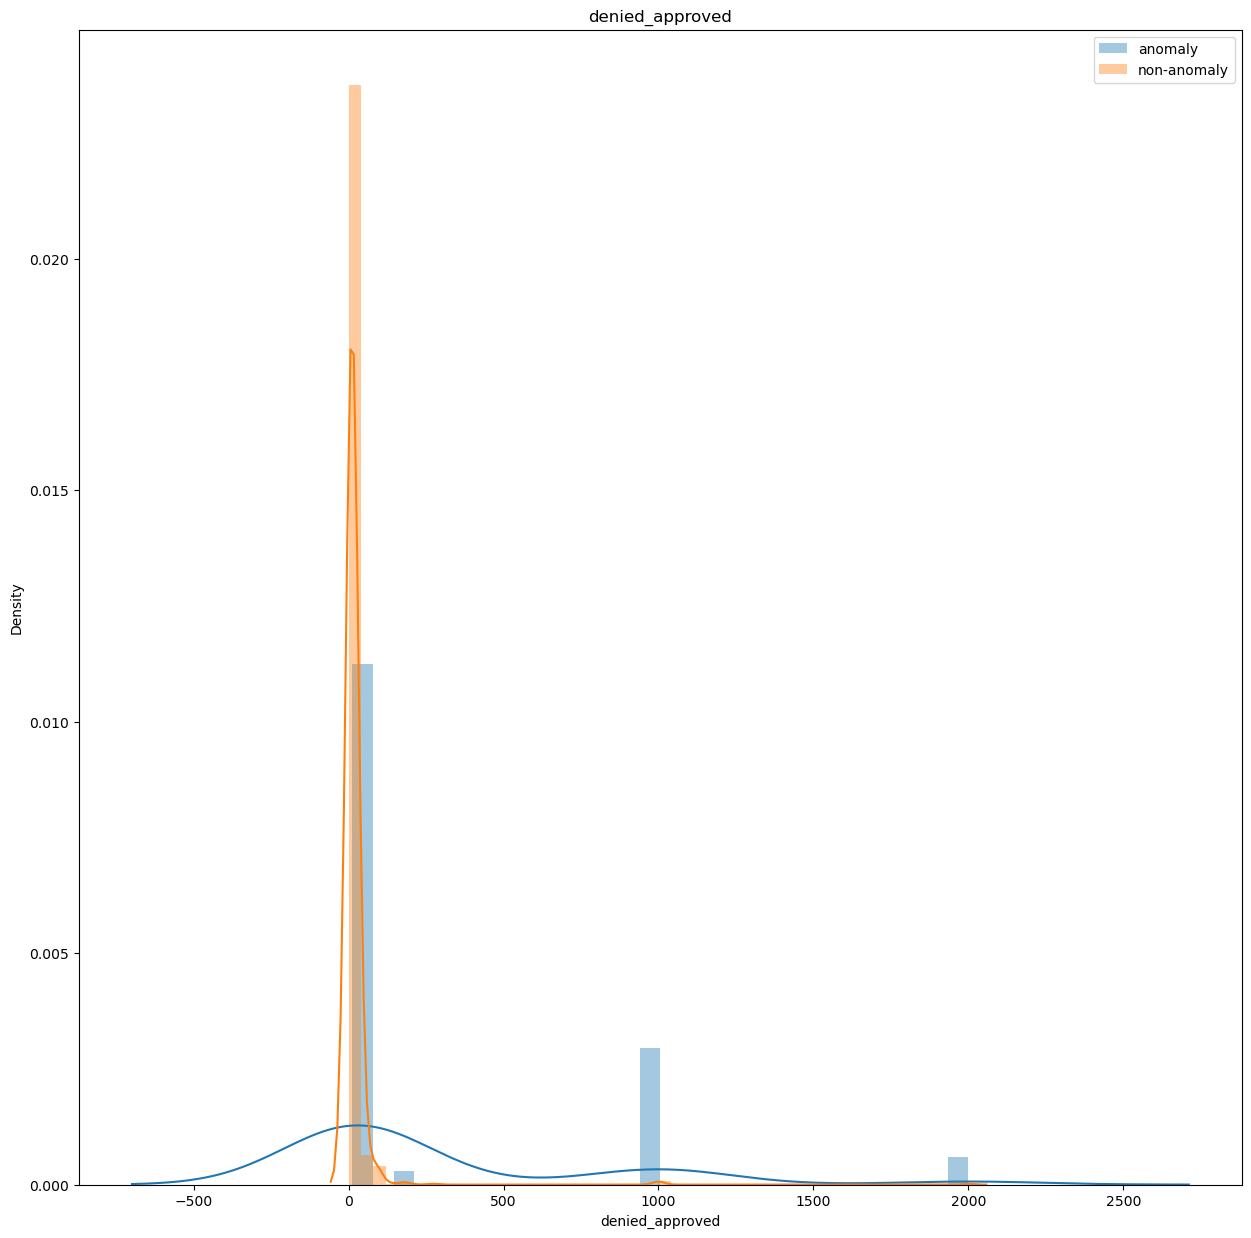

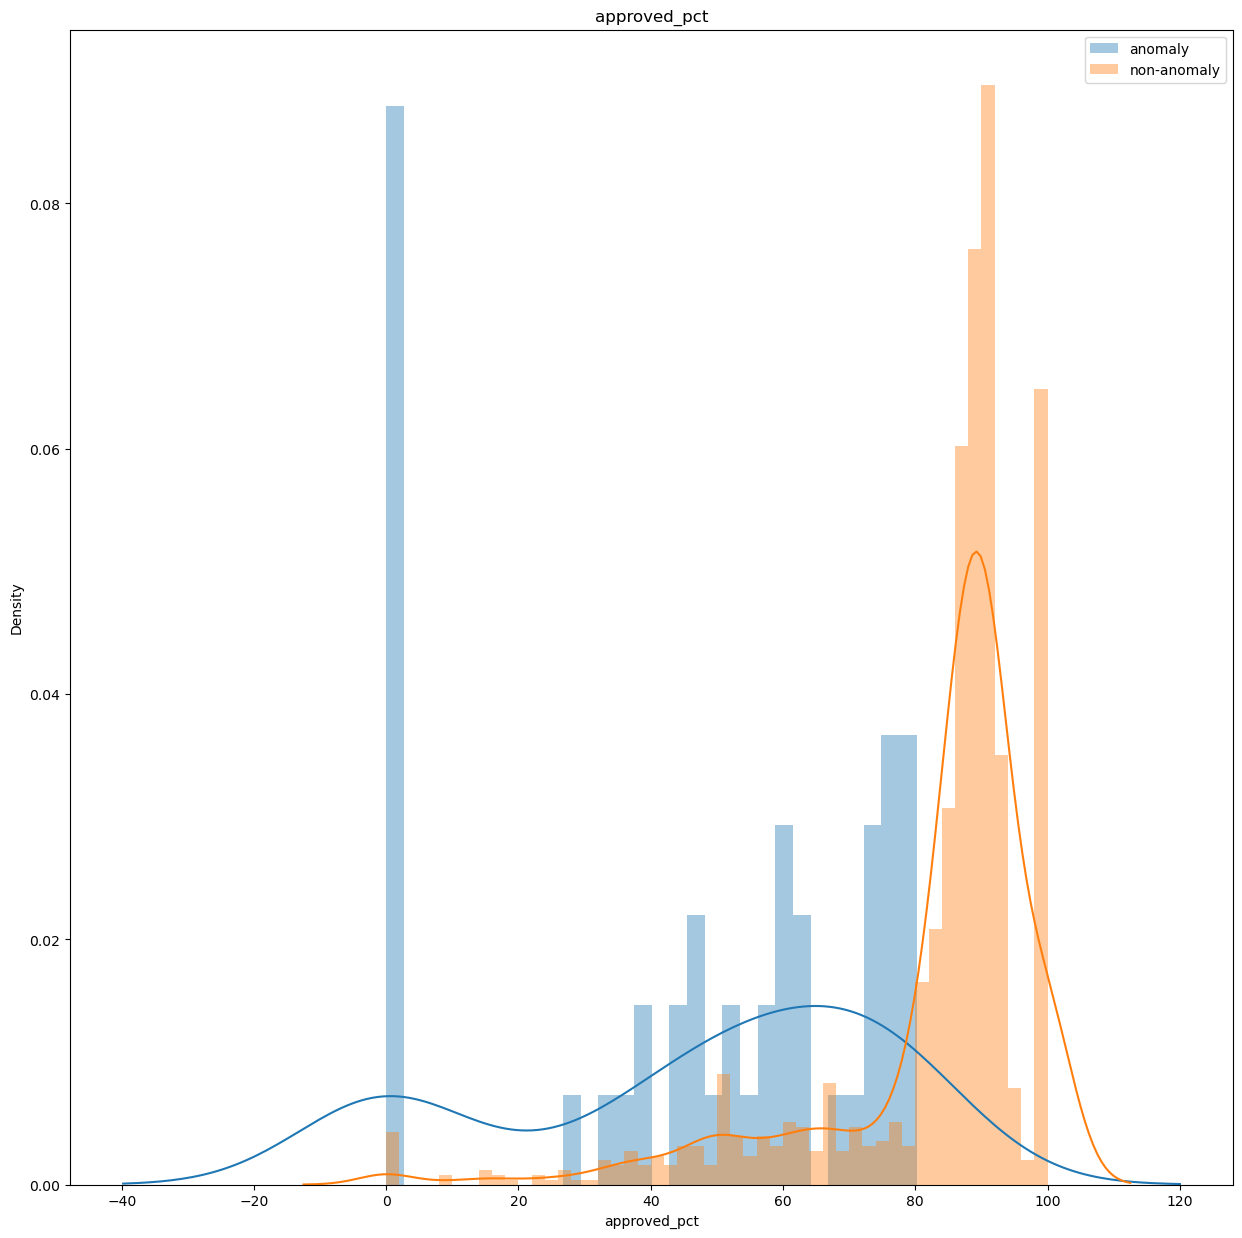

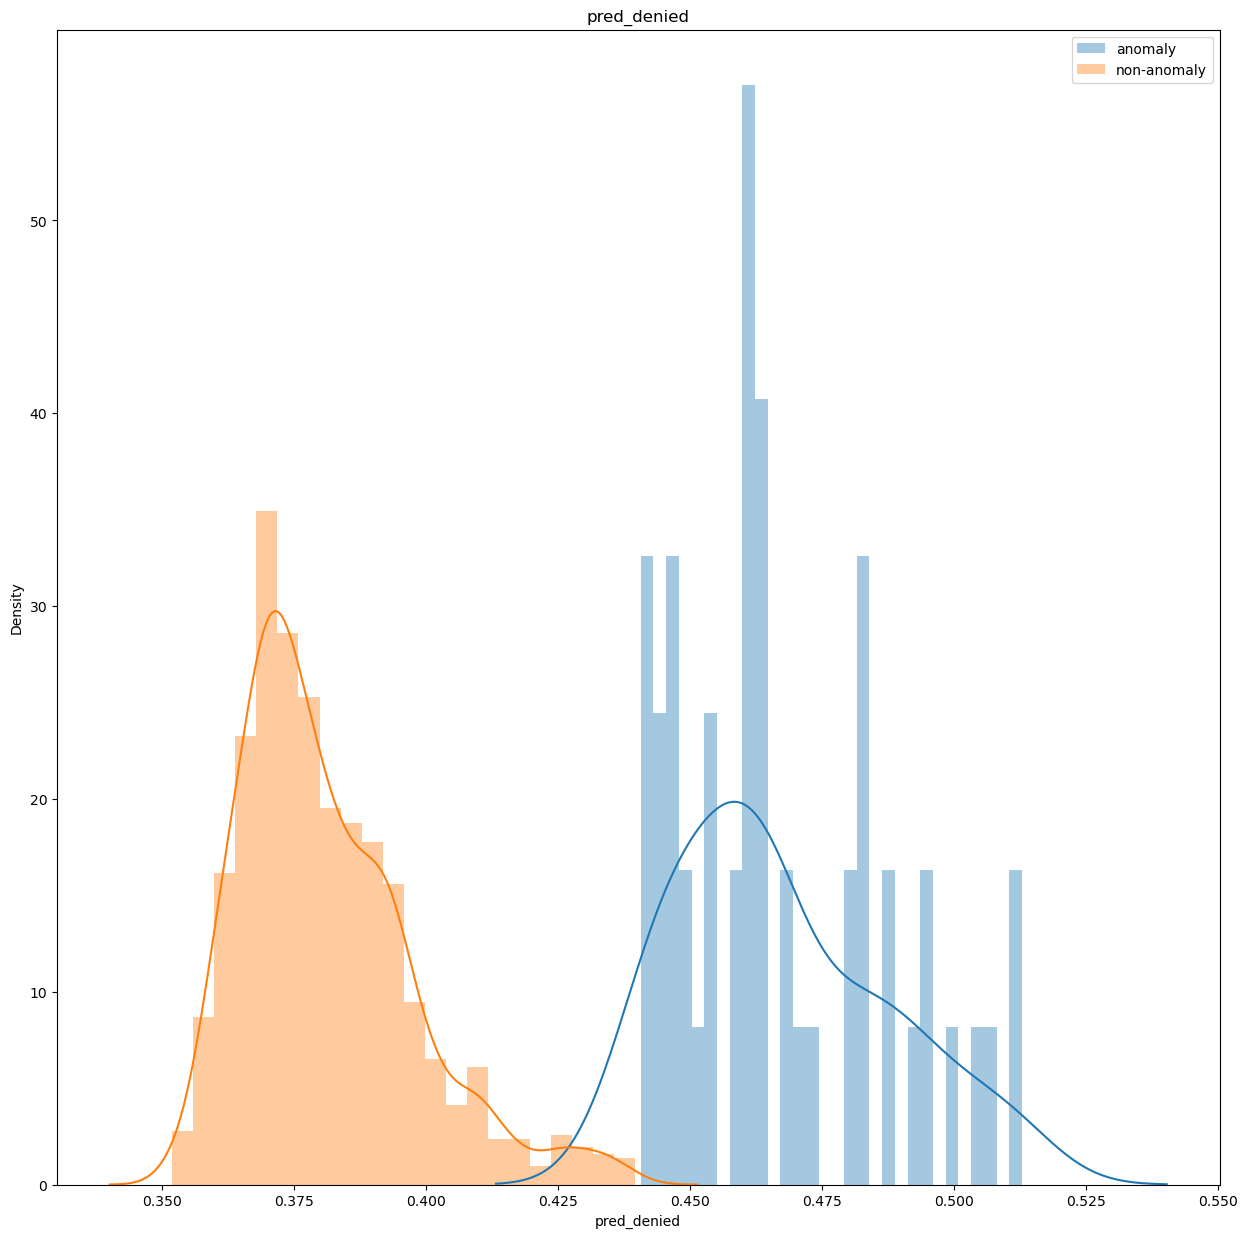

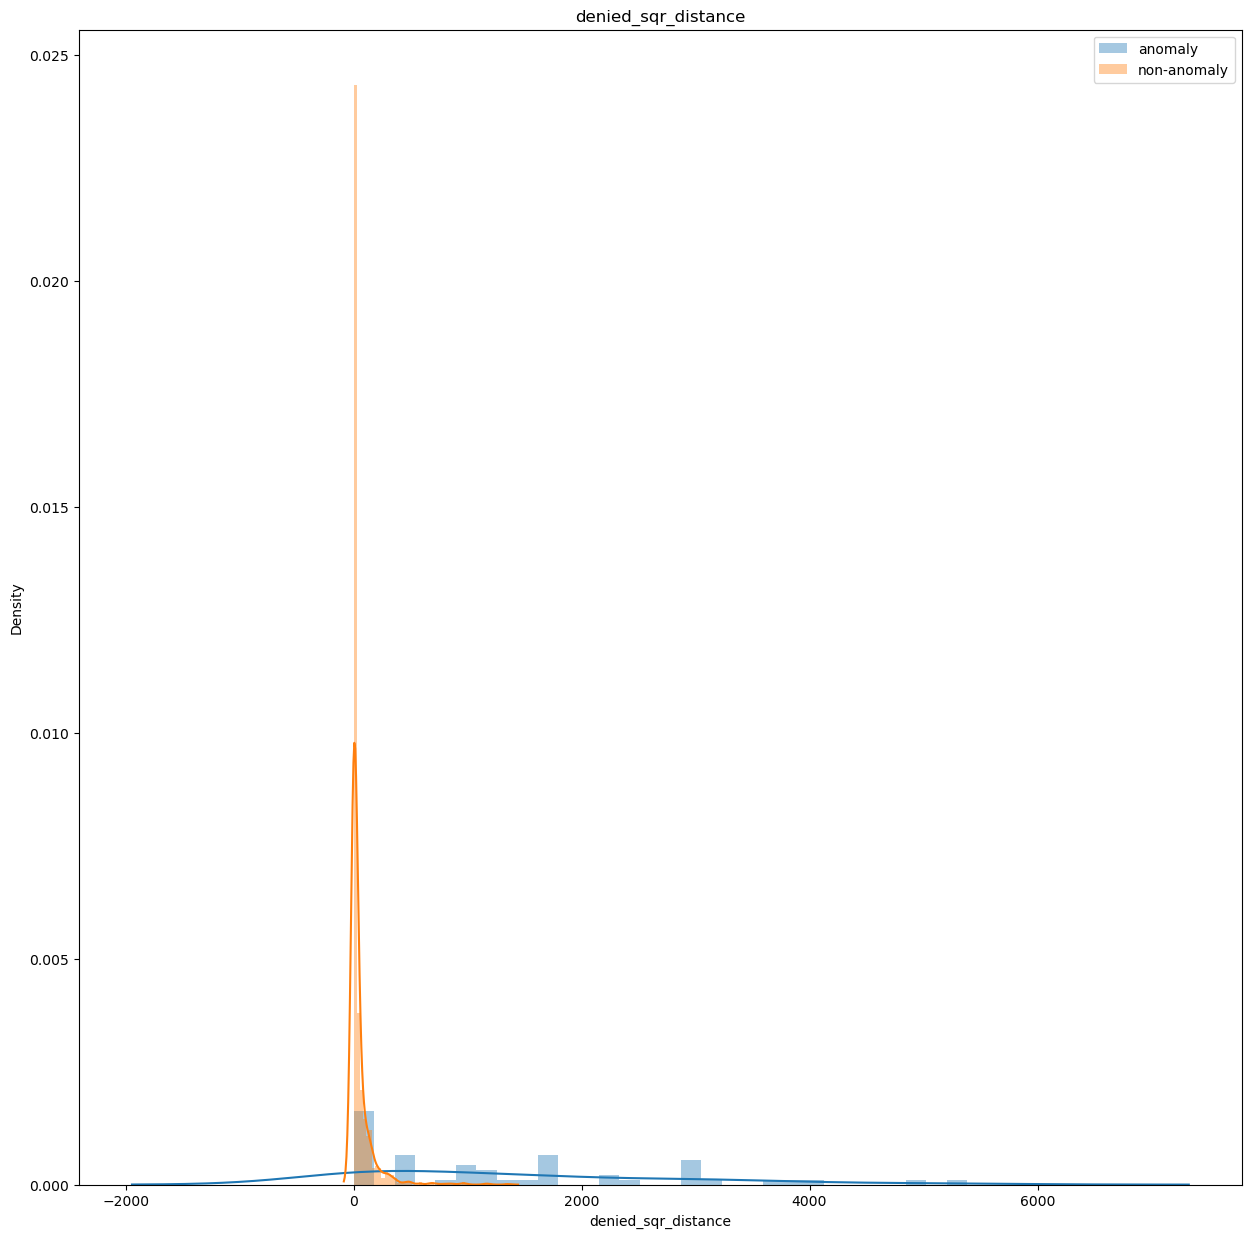

In [41]:
for i, col in enumerate(['approved','denied','denied_pct','denied_approved','approved_pct', 'pred_denied','denied_sqr_distance']):
    if col=='time':continue
    
    fig = plt.figure(figsize=(15,15))

  
    
    sns.distplot(predicted_df[predicted_df.anomaly_denied==True][col],label='anomaly', bins = 30)   
    sns.distplot(predicted_df[predicted_df.anomaly_denied==False][col], label='non-anomaly') 
    plt.legend()
    plt.title(col)


    plt.show()

In [68]:
predicted_df['anomaly_reversed'] = predicted_df.pred_reversed>0.47
predicted_df.groupby('anomaly_reversed').count()

,approved,denied,failed,processing,refunded,reversed,denied_approved,denied_pct,reversed_approved,reversed_pct,...,hour_19,hour_20,hour_21,hour_22,hour_23,pred_failed,pred_denied,pred_reversed,anomaly_failed,anomaly_denied
anomaly_reversed,,,,,,,,,,,,,,,,,,,,,
False,1292,1292,1292,1292,1292,1292,1292,1292,1292,1292,...,1292,1292,1292,1292,1292,1292,1292,1292,1292,1292
True,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30


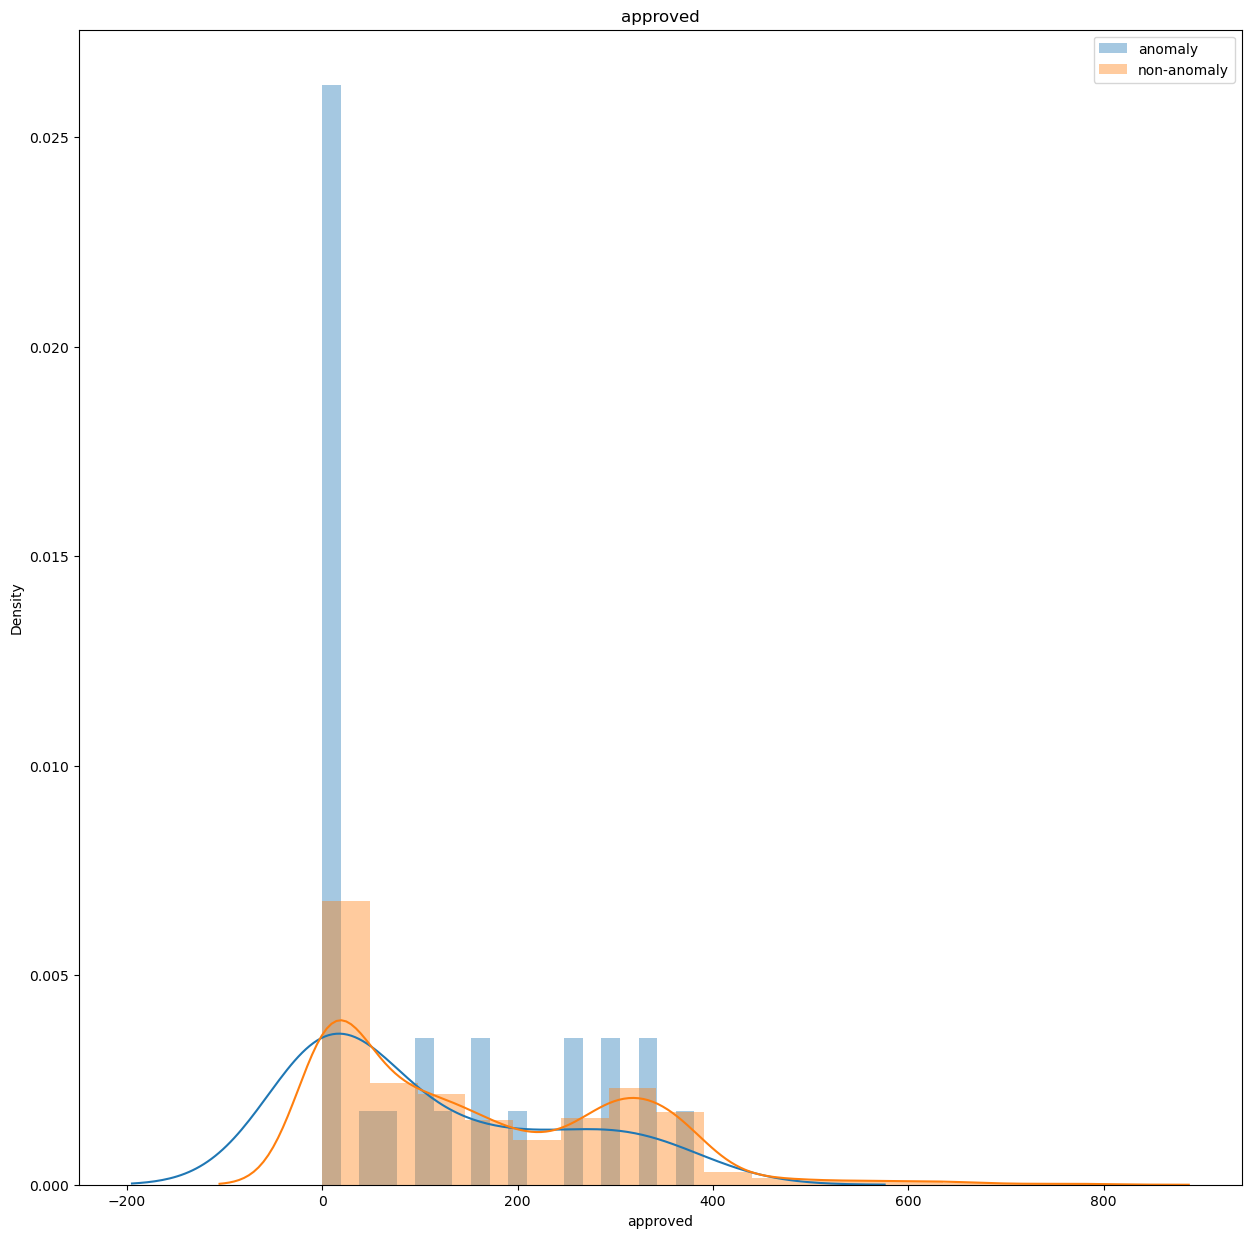

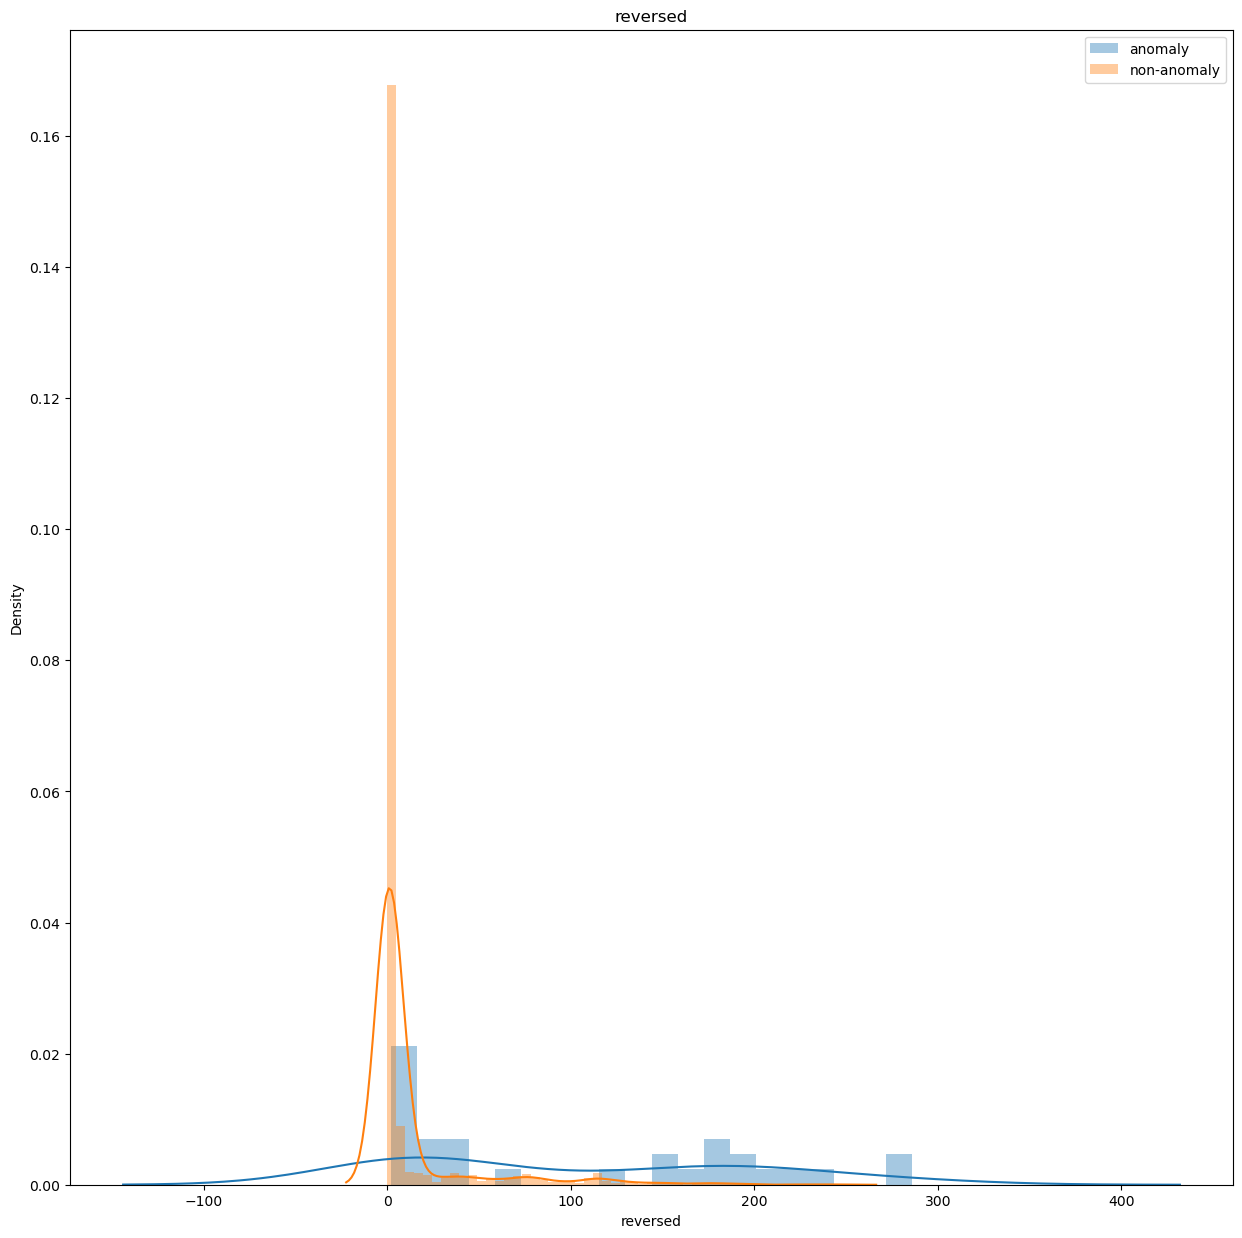

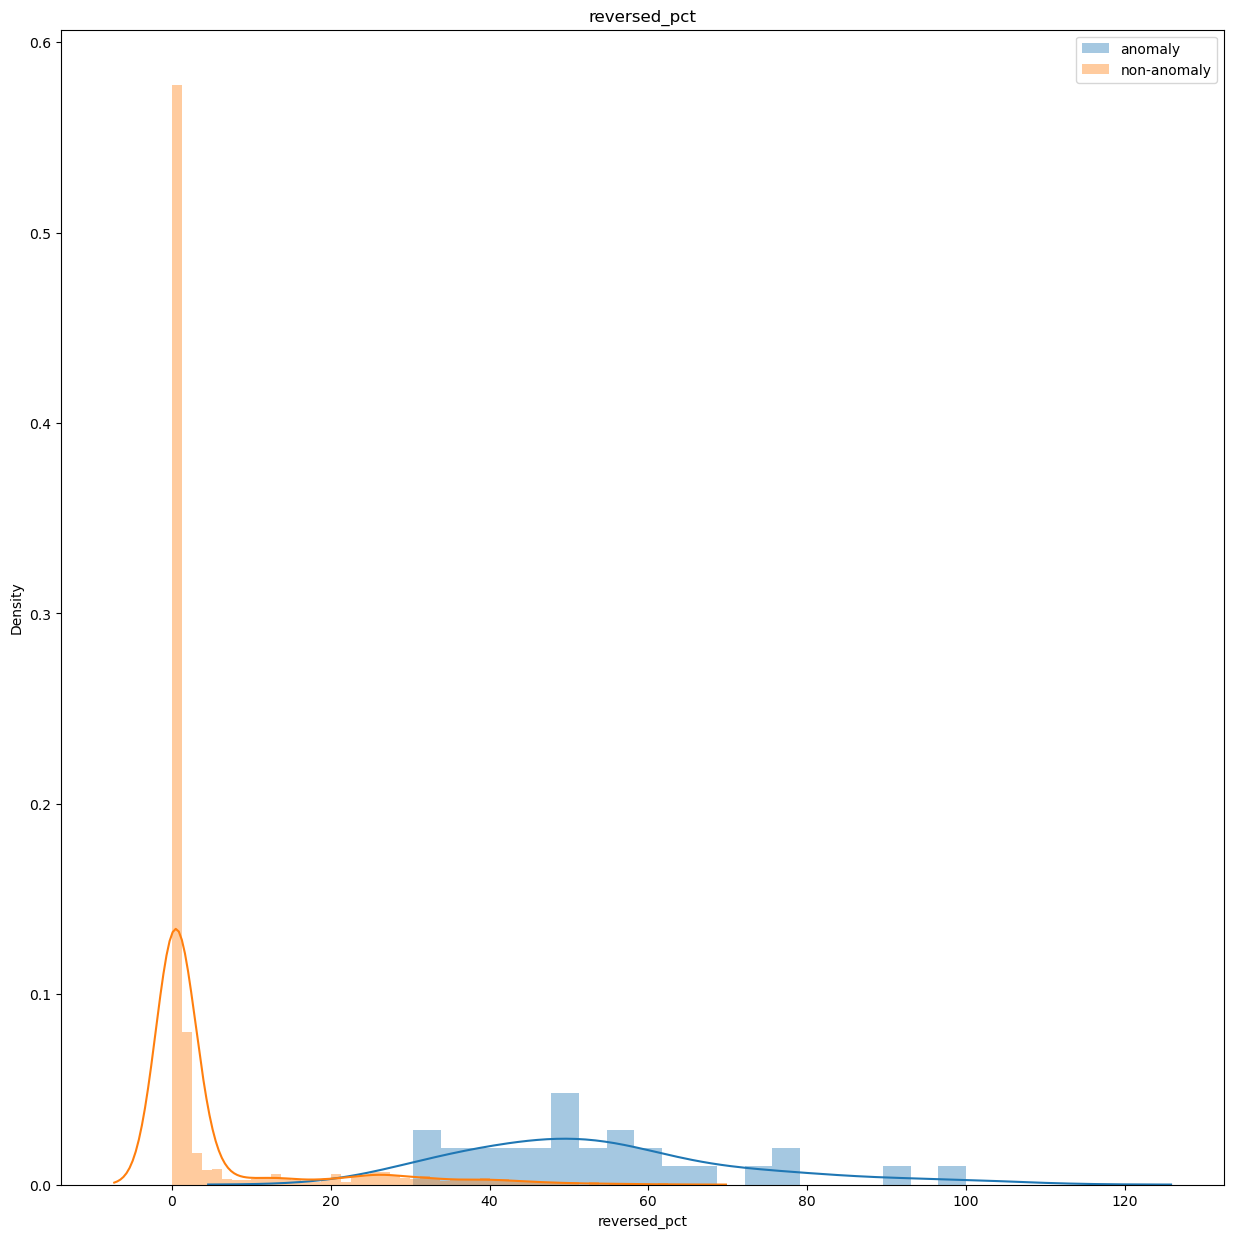

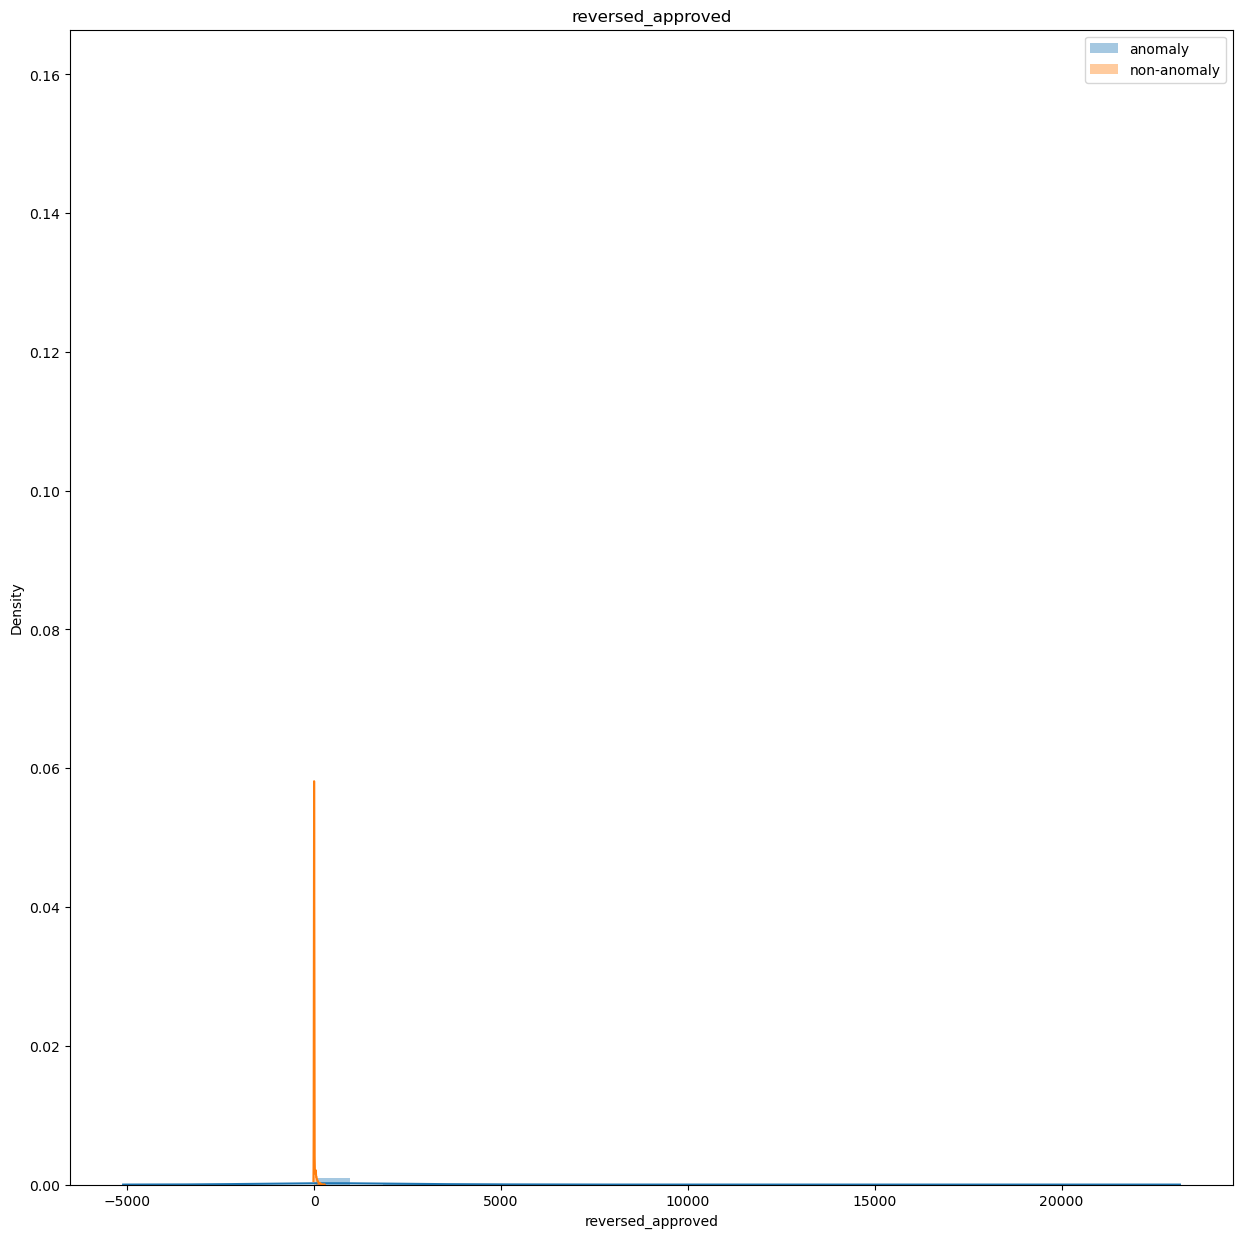

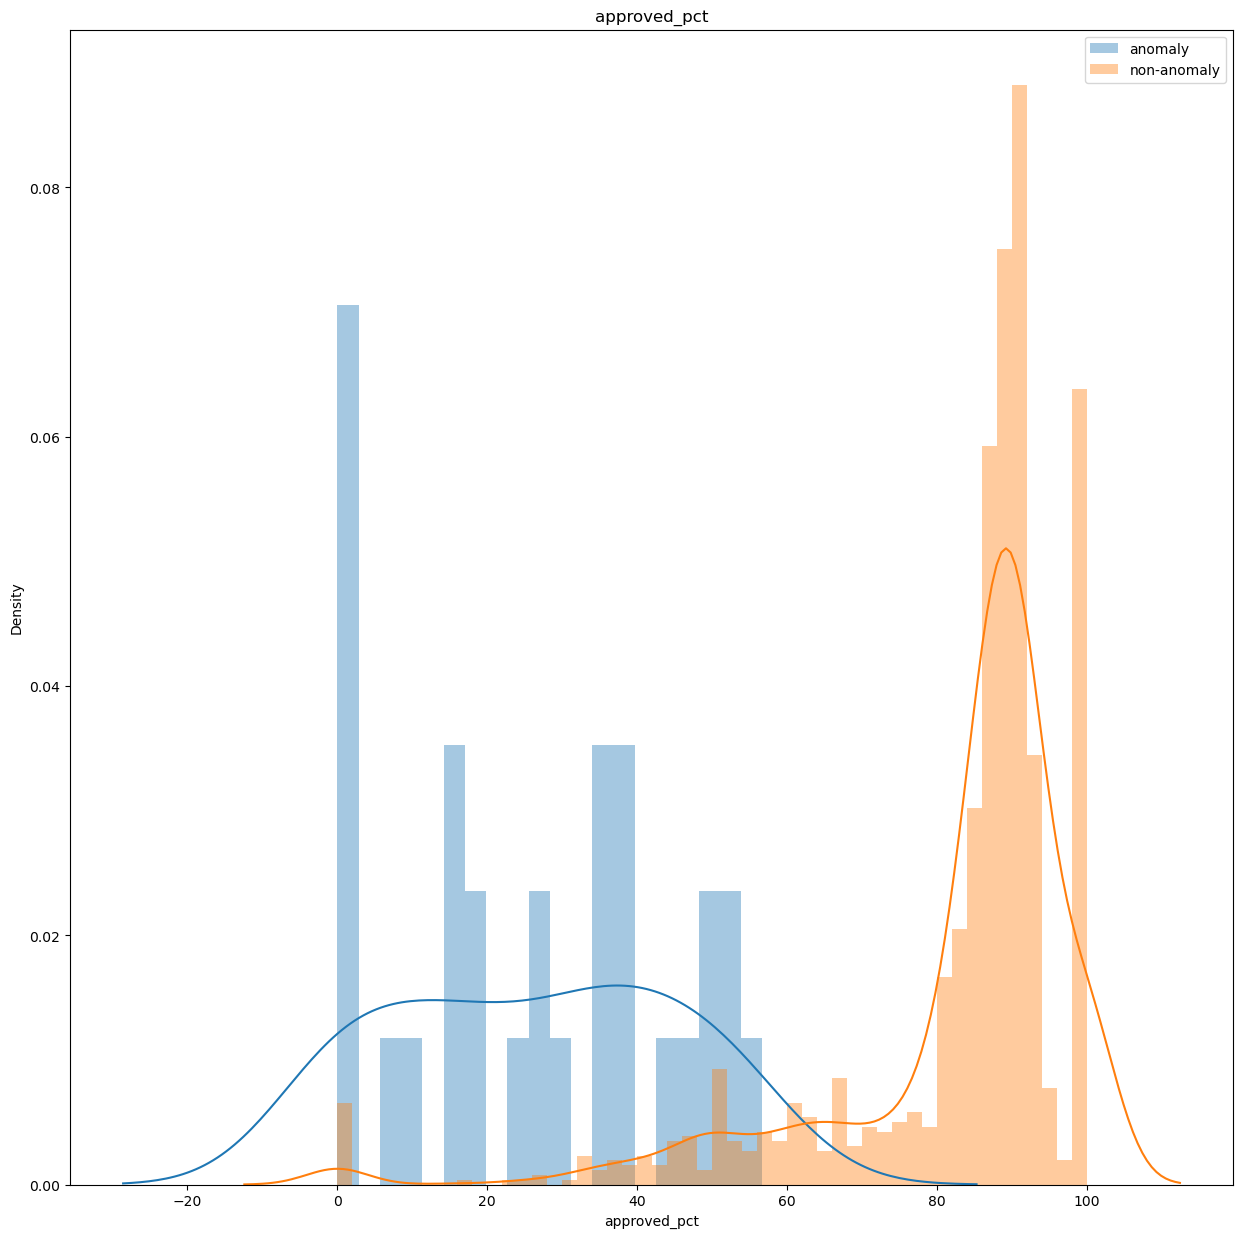

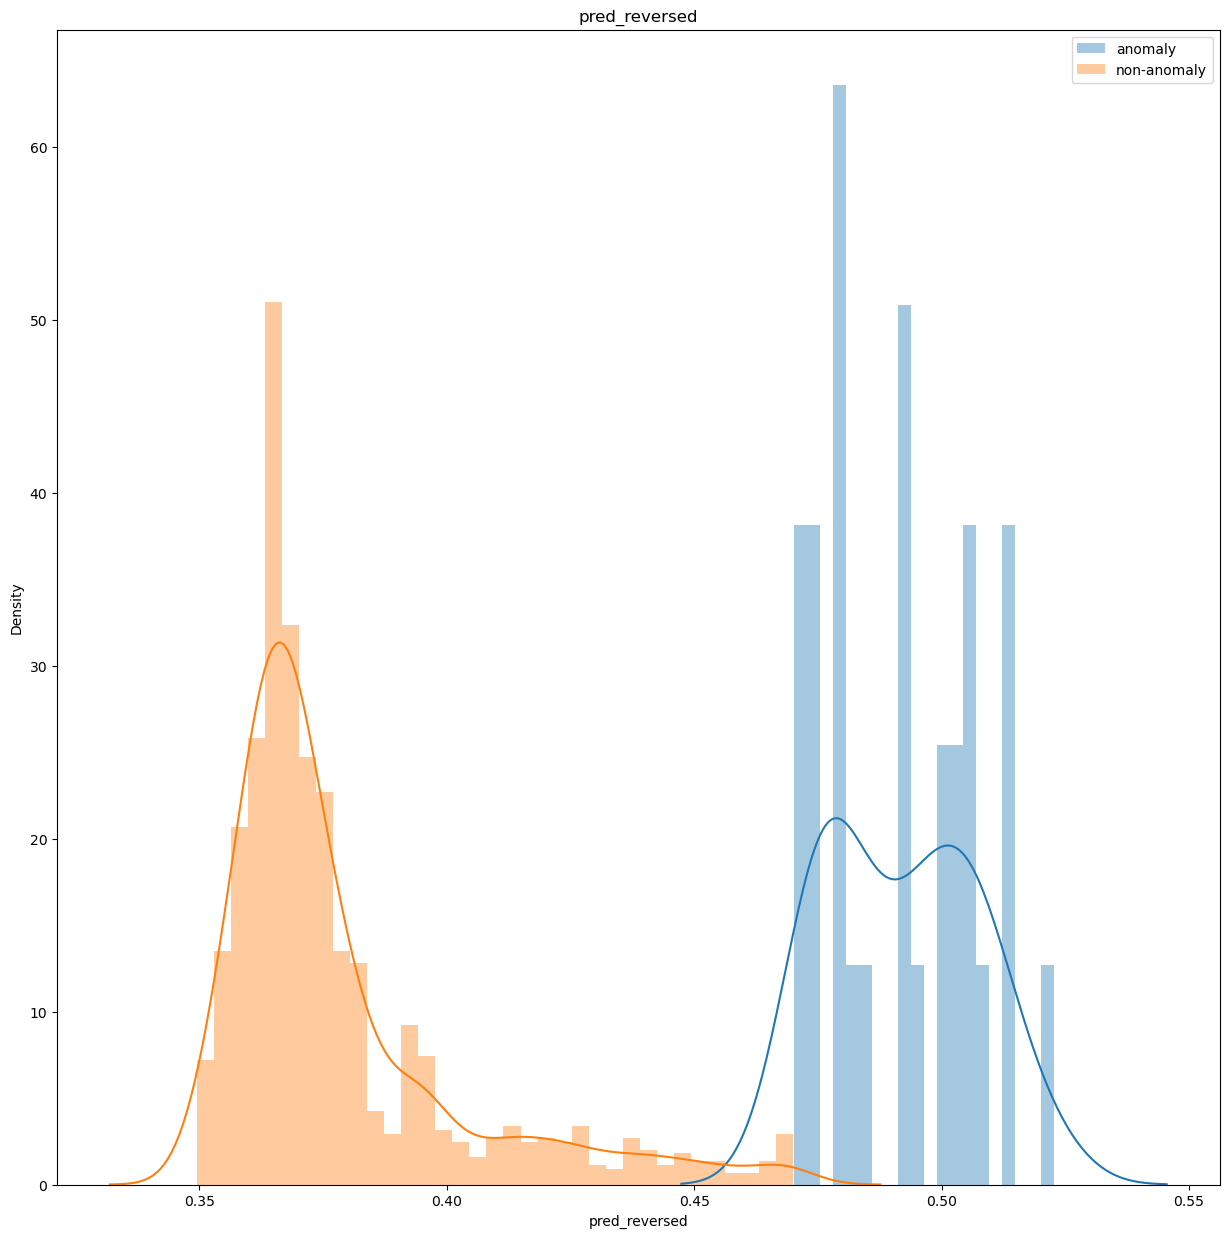

In [69]:
for i, col in enumerate(['approved','reversed','reversed_pct','reversed_approved','approved_pct','pred_reversed']):
    if col=='time':continue
    
    fig = plt.figure(figsize=(15,15))

  
    
    sns.distplot(predicted_df[predicted_df.anomaly_reversed==True][col],label='anomaly', bins=20)   
    sns.distplot(predicted_df[predicted_df.anomaly_reversed==False][col], label='non-anomaly') 
    plt.legend()
    plt.title(col)


    plt.show()

In [62]:
predicted_df['anomaly_reversed'] = predicted_df['anomaly_reversed'].astype(str)
predicted_df['anomaly_failed'] = predicted_df['anomaly_failed'].astype(str)
predicted_df['anomaly_denied'] = predicted_df['anomaly_denied'].astype(str)

<Axes: xlabel='reversed_pct', ylabel='approved_pct'>

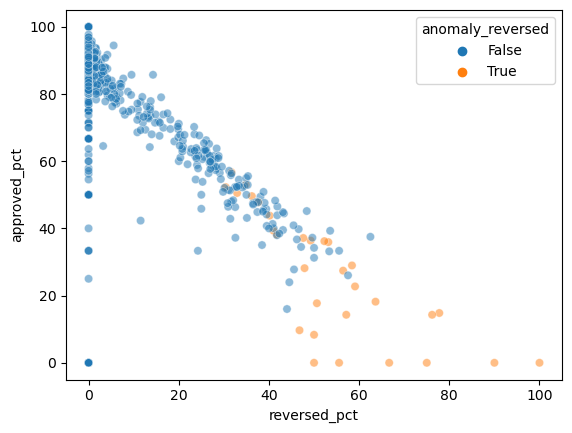

In [63]:
sns.scatterplot(x="reversed_pct", y="approved_pct", hue="anomaly_reversed", data=predicted_df, alpha=0.5)

<Axes: xlabel='denied_pct', ylabel='approved_pct'>

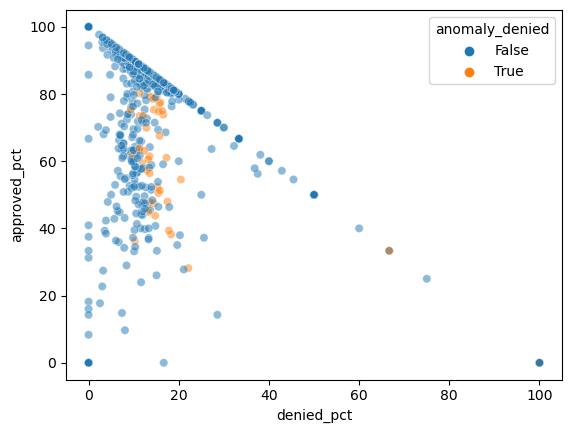

In [64]:
sns.scatterplot(x="denied_pct", y="approved_pct", hue="anomaly_denied", data=predicted_df, alpha=0.5, palette=[sns.color_palette()[0],sns.color_palette()[1]])

<Axes: xlabel='denied_pct', ylabel='approved_pct'>

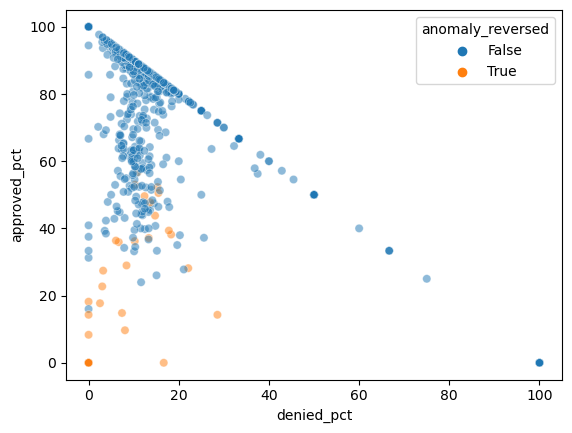

In [65]:
sns.scatterplot(x="denied_pct", y="approved_pct", hue="anomaly_reversed", data=predicted_df, alpha=0.5, palette=[sns.color_palette()[0],sns.color_palette()[1]])

<Axes: xlabel='failed_pct', ylabel='approved_pct'>

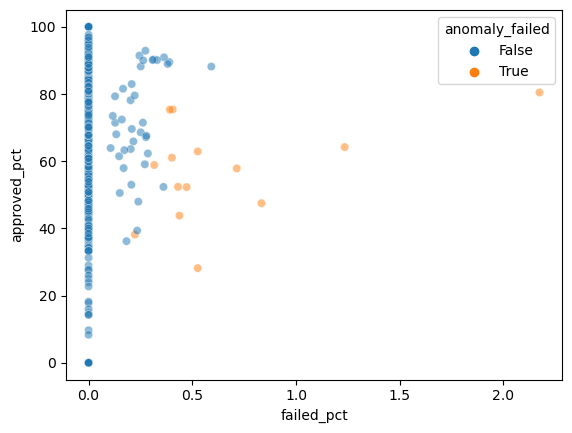

In [36]:
sns.scatterplot(x="failed_pct", y="approved_pct", hue="anomaly_failed", data=predicted_df, alpha=0.5)

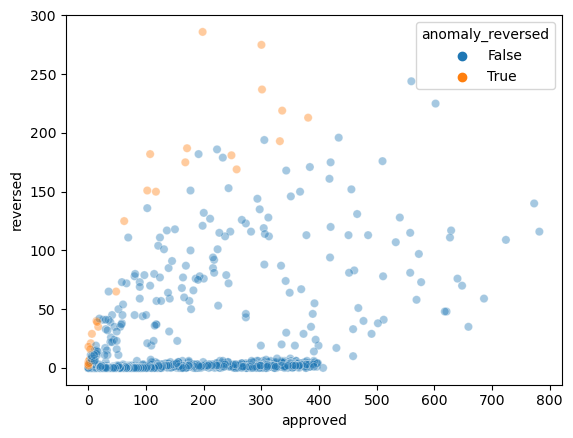

In [71]:
ax = sns.scatterplot(x="approved", y="reversed", hue="anomaly_reversed", data=predicted_df, alpha=0.4)

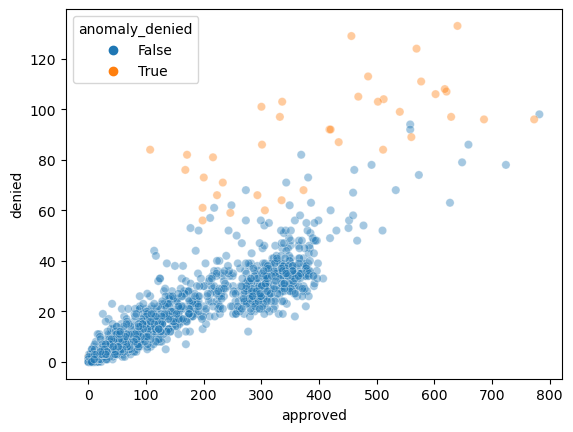

In [70]:
ax = sns.scatterplot(x="approved", y="denied", hue="anomaly_denied", data=predicted_df, alpha=0.4,palette=[sns.color_palette()[0],sns.color_palette()[1]])


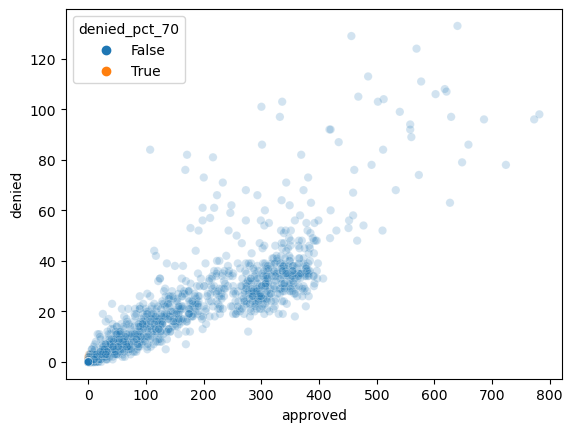

In [39]:
predicted_df['denied_pct_70'] = predicted_df['denied_pct']>=70
ax = sns.scatterplot(x="approved", y="denied", hue="denied_pct_70", data=predicted_df, alpha=0.2,palette=[sns.color_palette()[0],sns.color_palette()[1]])


(-1.0, 125.0)

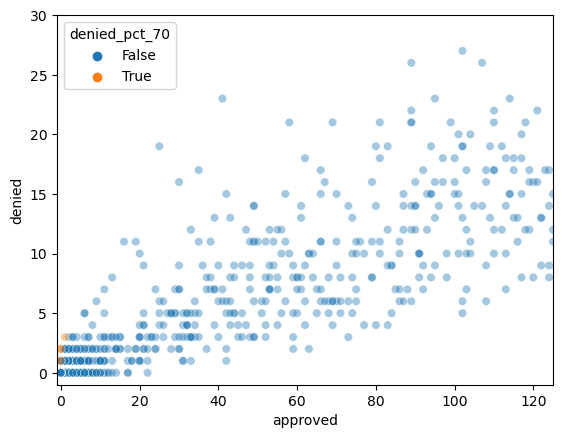

In [40]:
predicted_df['denied_pct_70'] = predicted_df['denied_pct']>=70
ax = sns.scatterplot(x="approved", y="denied", hue="denied_pct_70", data=predicted_df, alpha=0.4,palette=[sns.color_palette()[0],sns.color_palette()[1]])
ax.set_ylim([-1,30])
ax.set_xlim([-1,125])

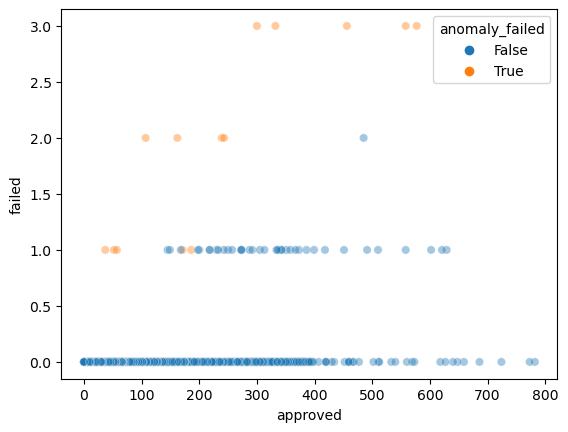

In [41]:
ax = sns.scatterplot(x="approved", y="failed", hue="anomaly_failed", data=predicted_df, alpha=0.4)

In [42]:
import joblib

joblib.dump(scaler, 'scaler.save')
joblib.dump(clf_failed, 'clf_failed.save')
joblib.dump(clf_denied, 'clf_denied.save')
joblib.dump(clf_reversed, 'clf_reversed.save')
joblib.dump(linearR_denied, 'linearR_denied.save')


['linearR_denied.save']